In [1]:
import pymultinest

In [2]:
import os
import sys
lines = open('htdihltotalls.txt').readlines() #打开文件，读入每一
fp = open('htdihltotalls.txt','w') #打开你要写得文件pp2.txt
for s in lines:
    fp.write(s.replace('*^','e'))
fp.close() # 关闭文件


In [ ]:
# Example of using bilby.core.likelihood functions
# Define a new likelihood function using bilby.core.likelihood

import sys
import os
import shutil
# 将 `code/Ringdown_gap_filling/Proj/` 添加到 sys.path
proj_dir = os.path.abspath(os.path.join(os.getcwd(), ".."))
if proj_dir not in sys.path:
    sys.path.append(proj_dir)
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import bilby
import corner
#from config.config import Config
from data.waveform import *
from data.ringdown_waveform import Gap_dir as Ga
Mtot_mean = 115000
Mtot_std= 5000
def model(time,M,M_ratio,R_shift,**kwargs):
    para=[M*Mtot_std+Mtot_mean,M_ratio,R_shift]
    freq_ifft = np.arange(Config.f_in, Config.f_out, Config.f_step)
    sf22, sf21,sf33, sf44 = sf_decomposition(freq_ifft, para, para_dw, para_dtau)
    sf = sf22 + sf21 + sf33 + sf44
    return Ga.Freq_ifft(sf)[1:1000]
class Config:
    parameters = [1.1e5, 1.2e5, 0.5, 0.7, 4, 6]
    signal_length = 1056
    f_in=1e-5
    f_out=1
    f_step=1e-5
M = np.random.uniform((Config.parameters[0]-Mtot_mean)/Mtot_std, (Config.parameters[1]-Mtot_mean)/Mtot_std)
M_ratio = np.random.uniform(Config.parameters[2], Config.parameters[3])
R_shift = np.random.uniform(Config.parameters[4], Config.parameters[5])
signal_length = Config.signal_length

para1 = [M*Mtot_std+Mtot_mean, M_ratio, R_shift]
freq_ifft = np.arange(Config.f_in, Config.f_out, Config.f_step)
f_sf22, f_sf21,f_sf33, f_sf44 = sf_decomposition(freq_ifft, para1, para_dw, para_dtau)
f_sf = f_sf22 + f_sf21 + f_sf33 + f_sf44
st = np.real(Ga.Freq_ifft(f_sf))

duration = 1 / Config.f_step 



n_points = len(freq_ifft) * 2  


# 时间轴
time = np.linspace(0, duration, n_points, endpoint=False)[1:1000]
yobs=st[1:1000]
import numpy as np
import bilby
from warnings import warn

class CustomLikelihood(bilby.Likelihood):
    def __init__(self, time, yobs, model):
        """
        增强稳定性的自定义似然函数
        
        参数:
            time : array_like
                时间序列数据
            yobs : array_like 
                观测值序列
            model : callable
                模型函数，形式为 model(time, **parameters)
        """
        parameters = dict(Mtot=None, M_ratio=None, R_shift=None)
        super().__init__(parameters=parameters)  # 正确传递字典

        self.time = time
        self.yobs = yobs
        self.model = model
        self.sigma = 1e-15
        self._last_valid_params = None

    def _validate_parameters(self):
        """ 参数物理性验证 """
        params = self.parameters
        conditions = [
            #params['Mtot'] > 0,             # 总质量必须为正
            0 < params['M_ratio'] <= 1,     # 质量比应在(0,1]区间
            params['R_shift'] > 0           # 红移必须为正
        ]
        return all(conditions)

    def _safe_predict(self):
        """ 带防护的模型预测 """
        try:
            # 对参数进行数值稳定处理
            safe_params = {
                'Mtot': max(1e-6, float(self.parameters['Mtot'])),
                'M_ratio': np.clip(self.parameters['M_ratio'], 1e-6, 1.0),
                'R_shift': max(1e-6, float(self.parameters['R_shift']))
            }
            
            prediction = self.model(self.time, **safe_params)
            self._last_valid_params = safe_params.copy()
            return prediction
            
        except (TypeError, ValueError) as e:
            warn(f"参数错误: {e}\n使用最后有效参数: {self._last_valid_params}")
            return self.model(self.time, **self._last_valid_params) if self._last_valid_params else np.zeros_like(self.yobs)

    def log_likelihood(self):
        """
        带数值保护的改进对数似然计算
        """
        # 参数有效性检查
        if not self._validate_parameters():
            return -np.inf

        # 获取模型预测（带保护）
        prediction = self._safe_predict()
        
        # 处理潜在复数结果（即使经过防护）
        residual = np.asarray(self.yobs - prediction).real
        
        # 带数值保护的似然计算
        sigma_sq = max(1e-16, float(self.sigma**2))
        chi_sq = np.sum(np.square(np.divide(residual, self.sigma, 
                                          out=np.zeros_like(residual),
                                          where=abs(self.sigma)>1e-10)))
        
        log_norm = 0.5 * len(self.yobs) * np.log(2 * np.pi * sigma_sq)
        
        log_l = -0.5 * chi_sq - log_norm
        
        # 最终实数强制转换
        return float(np.real_if_close(log_l, tol=1e6))

    # 诊断工具
    def print_diagnostics(self):
        """ 输出当前计算状态的诊断信息 """
        pred = self._safe_predict()
        resid = self.yobs - pred
        print("\n=== 诊断信息 ===")
        print(f"当前参数: {self.parameters}")
        print(f"预测值范围: [{np.min(pred):.3g}, {np.max(pred):.3g}]")
        print(f"残差统计: 均值={np.mean(resid):.3g}, 标准差={np.std(resid):.3g}")
        print(f"最大绝对残差: {np.max(np.abs(resid)):.3g}")


# Example usage
custom_likelihood = CustomLikelihood(time, yobs, model)
# priors = dict(
#     Mtot=bilby.core.prior.Uniform(Config.parameters[0], Config.parameters[1]),
#     M_ratio=bilby.core.prior.Uniform(Config.parameters[2], Config.parameters[3]),
#     R_shift=bilby.core.prior.Uniform(Config.parameters[4], Config.parameters[5])
# )
from bilby.core.prior import PriorDict, Uniform

priors = PriorDict()  # 关键修复：使用 Bilby 的 PriorDict
M_min= (Config.parameters[0]-Mtot_mean)/Mtot_std
M_max= (Config.parameters[1]-Mtot_mean)/Mtot_std
priors["Mtot"] = Uniform(minimum=M_min, maximum=M_max, name="Mtot", latex_label=r"$M_{\rm tot}$")
#priors["Mtot"] = Uniform(minimum=110000, maximum=120000, name="Mtot", latex_label=r"$M_{\rm tot}$")
priors["M_ratio"] = Uniform(minimum=0.9, maximum=1, name="M_ratio", latex_label=r"$q$")
priors["R_shift"] = Uniform(minimum=4, maximum=6, name="R_shift", latex_label=r"$\Delta R$")
print("Priors 类型检查:", type(priors))  # 应输出 <class 'bilby.core.prior.PriorDict'>


# 随机生成5个先验点验证似然多样性
# for _ in range(5):
#     params = priors.sample()
#     lnL = custom_likelihood.log_likelihood()
#     print(f"Params: {params} → lnL={lnL}")

# 如果输出现类似：
# Params: {'Mtot':111000, 'M_ratio':0.95, ...} → lnL=-231.5
# Params: {'Mtot':115000, 'M_ratio':0.93, ...} → lnL=-240.1 → 正常
# 如果所有lnL相同 → 模型存在严重问题


print("Likelihood parameters before sampling:", custom_likelihood.parameters)
print("Priors keys:", priors.keys())
import logging
logging.basicConfig(level=logging.DEBUG)  # 强制输出内部日志

output_dir = "custom_model_output_1"
if os.path.exists(output_dir):
    shutil.rmtree(output_dir)
os.makedirs(output_dir, exist_ok=True)

result = bilby.run_sampler(
    likelihood=custom_likelihood,
    priors=priors,
    sampler="bilby_mcmc",
    nwalkers=24,       # 3参数 → 3*8=24（适中的冗余）
    nsamples=10000,    # 总步数10000（含预烧）
    nburn=3000,        # 预烧3000步 
    a=1.8,             # 控制跳跃幅度以匹配归一化参数
    moves="stretch",   # 对低维问题单一策略足矣
    printdt=60,
    outdir=output_dir,
    label="optimized_mcmc"
)


In [10]:
#lisa
import json
import sys
import numpy
from numpy import log, exp, pi,sqrt,cos,sin,abs,log10,abs,e
import scipy.stats, scipy
import pymultinest
import matplotlib.pyplot as plt
#datafile = sys.argv[1]
data = numpy.loadtxt('htdihltotalls.txt', dtype='complex',)
#np.loadtxt('./data/GammaT_mean.txt', dtype='complex')
#data = numpy.genfromtxt('htdihltotalls.txt',delimiter=',',dtype='str')
#mapping = numpy.vectorize(lambda t:complex())
#p1= mapping(data)
#beam_data = pd.read_csv("beam1.csv").astype('complex')
#print(data)
'''olds = ['i', '^']
news = ['j', '*']
filename='htdihltotalls.csv'#csv数据为复数
temp = numpy.genfromtxt(filename, delimiter=',',dtype='str')
mapping = numpy.vectorize(lambda t:complex(t.replace(olds,news)))
#mapping = numpy.vectorize(lambda t:complex(t.replace('i','j'),t.replace('^','*')))
p1= mapping(temp)'''

pc = 3.26*9.46*10**15
Ms = 1.99*10**30
c = 3*10**8
cG = 6.67*10**-11
def A1(v):
    return 0.864*v

def  A3(v):
    return 0.44*(1 - 4*v)**0.45*A1(v)
#print(A3(0.1))

def  w1(m,b,a):
  return ((0.3736*(1 - 0.03135*b**2 - 0.09674*b**3 + 0.2375*b**4) + 
   2*a*(0.0629 - 0.0156*b**2 - 0.00758*b**3 - 0.0644*b**4 + 0.268*b**5 - 
      0.603*b**6))*c**3)/(cG*((10**m)*Ms))
#print(w1(1.99*10**36,0.1,0.01))  
def  tau1(m,b,a):
  return 1/((((0.0888)*(1 + 0.04371*b**2 + 0.1794*b**3 - 0.2947*b**4) + 
      2*a*(0.00099 - 0.0011*b**2 + 0.01864*b**3 - 0.17271*b**4 + 
         0.56422*b**5 - 0.8119*b**6))*c**3)/(cG*((10**m)*Ms)))
#print(tau1(1.99*10**36,0.1,0.01)) 
def  w3(m,b,a):
     return ((0.5994*(1 - 0.09911*b**2 - 0.04907*b**3 + 0.09286*b**4) + 
   3*a*(0.0674 - 0.0291*b**2 + 0.0251*b**3 - 0.3209*b**4 + 1.1703*b**5 - 
      1.3341*b**6))*c**3)/(cG*((10**m)*Ms))
#print(w3(1.99*10**36,0.1,0.01))
def  tau3(m,b,a):
  return 1/((((0.0927)*(1 + 0.07710*b**2 + 0.1399*b**3 - 0.3450*b**4) + 
     3*a*(0.00065 + 0.00023*b**2 + 0.0233*b**3 - 0.2832*b**4 + 
        1.323*b**5 - 2.442*b**6))*c**3)/(cG*((10**m)*Ms)))
#print(tau3(1.99*10**36,0.1,0.01))
Psi=pi/3
Phi0=0
Theta=0
t0=0
'''fa=[0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1, 0.11, \
0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2, 0.21, 0.22, \
0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.3, 0.31, 0.32, 0.33, \
0.34, 0.35, 0.36, 0.37, 0.38, 0.39, 0.4, 0.41, 0.42, 0.43, 0.44, \
0.45, 0.46, 0.47, 0.48, 0.49, 0.5, 0.51, 0.52, 0.53, 0.54, 0.55, \
0.56, 0.57, 0.58, 0.59, 0.6, 0.61, 0.62, 0.63, 0.64, 0.65, 0.66, \
0.67, 0.68, 0.69, 0.7, 0.71, 0.72, 0.73, 0.74, 0.75, 0.76, 0.77, \
0.78, 0.79, 0.8, 0.81, 0.82, 0.83, 0.84, 0.85, 0.86, 0.87, 0.88, \
0.89, 0.9, 0.91, 0.92, 0.93, 0.94, 0.95, 0.96, 0.97, 0.98, 0.99, 1]'''
fa=numpy.loadtxt('f.txt')
f=numpy.array(fa)
#print(f)

'''def model1(M, v, x, t0,Phi,a,b,r):
  h=cG*M*sqrt(5/pi)*A1(v)*cos(x)*cos(Theta)*cos(2*Psi)*sin(2*Phi0)\
   *(((-cos(f*t0 + 2*Phi)*1j + sin(f*t0 + 2*Phi))*1j*tau1(M,b,a))/(2*sqrt(2*pi)*(1j+f*tau1(M,b,a)-tau1(M,b,a)*w1(M,b,a)))\
   -((cos(f*t0 - 2*Phi) + sin(f*t0 - 2*Phi)*1j)*tau1(M,b,a))/(2*sqrt(2*pi)*(1j + f*tau1(M,b,a) + tau1(M,b,a)*w1(M,b,a))))/(2*c**2*r)\
   +cG*M*sqrt(5/pi)*A1(v)*cos(x)*cos(2*Phi0)*sin(2*Psi)\
   *(((-cos(f*t0 + 2*Phi)*1j + sin(f*t0 + 2*Phi))*1j*tau1(M,b,a))/(2*sqrt(2*pi)*(1j+f*tau1(M,b,a)-tau1(M,b,a)*w1(M,b,a)))\
   -((cos(f*t0 - 2*Phi) + sin(f*t0 - 2*Phi)*1j)*tau1(M,b,a))/(2*sqrt(2*pi)*(1j + f*tau1(M,b,a) + tau1(M,b,a)*w1(M,b,a))))/(4*c**2*r)\
   +cG*M*sqrt(5/pi)*A1(v)*cos(x)*cos(Theta)**2*cos(2*Phi0)*sin(2*Psi)\
   *(((-cos(f*t0 + 2*Phi)*1j + sin(f*t0 + 2*Phi))*1j*tau1(M,b,a))/(2*sqrt(2*pi)*(1j+f*tau1(M,b,a)-tau1(M,b,a)*w1(M,b,a)))\
   -((cos(f*t0 - 2*Phi) + sin(f*t0 - 2*Phi)*1j)*tau1(M,b,a))/(2*sqrt(2*pi)*(1j + f*tau1(M,b,a) + tau1(M,b,a)*w1(M,b,a))))/(4*c**2*r)\
   +cG*M*sqrt(5/pi)*A1(v)*cos(2*Phi0)*cos(2*Psi)\
   *(((cos(f*t0 + 2*Phi) + sin(f*t0 + 2*Phi)*1j)*1j*tau1(M,b,a))/(2*sqrt(2*pi)*(1j+f*tau1(M,b,a)-tau1(M,b,a)*w1(M,b,a)))\
   +((cos(f*t0 - 2*Phi) + sin(f*t0 - 2*Phi)*1j)*1j*tau1(M,b,a))/(2*sqrt(2*pi)*(1j + f*tau1(M,b,a) + tau1(M,b,a)*w1(M,b,a))))/(8*c**2*r)\
   +cG*M*sqrt(5/pi)*A1(v)*cos(x)**2*cos(2*Phi0)*cos(2*Psi)\
   *(((cos(f*t0 + 2*Phi) + sin(f*t0 + 2*Phi)*1j)*1j*tau1(M,b,a))/(2*sqrt(2*pi)*(1j+f*tau1(M,b,a)-tau1(M,b,a)*w1(M,b,a)))\
   +((cos(f*t0 - 2*Phi) + sin(f*t0 - 2*Phi)*1j)*1j*tau1(M,b,a))/(2*sqrt(2*pi)*(1j + f*tau1(M,b,a) + tau1(M,b,a)*w1(M,b,a))))/(8*c**2*r)\
   +cG*M*sqrt(5/pi)*A1(v)*cos(Theta)**2*cos(2*Phi0)*cos(2*Psi)\
   *(((cos(f*t0 + 2*Phi) + sin(f*t0 + 2*Phi)*1j)*1j*tau1(M,b,a))/(2*sqrt(2*pi)*(1j+f*tau1(M,b,a)-tau1(M,b,a)*w1(M,b,a)))\
   +((cos(f*t0 - 2*Phi) + sin(f*t0 - 2*Phi)*1j)*1j*tau1(M,b,a))/(2*sqrt(2*pi)*(1j + f*tau1(M,b,a) + tau1(M,b,a)*w1(M,b,a))))/(8*c**2*r)\
   +cG*M*sqrt(5/pi)*A1(v)*cos(x)**2*cos(Theta)**2*cos(2*Phi0)*cos(2*Psi)\
   *(((cos(f*t0 + 2*Phi) + sin(f*t0 + 2*Phi)*1j)*1j*tau1(M,b,a))/(2*sqrt(2*pi)*(1j+f*tau1(M,b,a)-tau1(M,b,a)*w1(M,b,a)))\
   +((cos(f*t0 - 2*Phi) + sin(f*t0 - 2*Phi)*1j)*1j*tau1(M,b,a))/(2*sqrt(2*pi)*(1j + f*tau1(M,b,a) + tau1(M,b,a)*w1(M,b,a))))/(8*c**2*r)\
   -cG*M*sqrt(5/pi)*A1(v)*cos(Theta)*cos(Phi0)*cos(Psi)*sin(Phi0)*sin(Psi)\
   *(((cos(f*t0 + 2*Phi) + sin(f*t0 + 2*Phi)*1j)*1j*tau1(M,b,a))/(2*sqrt(2*pi)*(1j+f*tau1(M,b,a)-tau1(M,b,a)*w1(M,b,a)))\
   +((cos(f*t0 - 2*Phi) + sin(f*t0 - 2*Phi)*1j)*1j*tau1(M,b,a))/(2*sqrt(2*pi)*(1j + f*tau1(M,b,a) + tau1(M,b,a)*w1(M,b,a))))/(c**2*r)\
   -cG*M*sqrt(5/pi)*A1(v)*cos(x)**2*cos(Theta)*cos(Phi0)*cos(Psi)*sin(Phi0)*sin(Psi)\
   *(((cos(f*t0 + 2*Phi) + sin(f*t0 + 2*Phi)*1j)*1j*tau1(M,b,a))/(2*sqrt(2*pi)*(1j+f*tau1(M,b,a)-tau1(M,b,a)*w1(M,b,a)))\
   +((cos(f*t0 - 2*Phi) + sin(f*t0 - 2*Phi)*1j)*1j*tau1(M,b,a))/(2*sqrt(2*pi)*(1j + f*tau1(M,b,a) + tau1(M,b,a)*w1(M,b,a))))/(c**2*r)\
   -cG*M*sqrt(21/(2*pi))*A3(v)*cos(x)*cos(Theta)*cos(2*Psi)*sin(x)*sin(2*Phi0)\
   *(((-cos(f*t0 + 3*Phi)*1j + sin(f*t0 + 3*Phi))*1j*tau3(M,b,a))/(2*sqrt(2*pi)*(1j+f*tau3(M,b,a)-tau3(M,b,a)*w3(M,b,a)))\
   -((cos(f*t0 - 3*Phi) + sin(f*t0 - 3*Phi)*1j)*tau3(M,b,a))/(2*sqrt(2*pi)*(1j + f*tau3(M,b,a) + tau3(M,b,a)*w3(M,b,a))))/(2*c**2*r)\
   -cG*M*sqrt(21/(2*pi))*A3(v)*cos(x)*cos(2*Phi0)*sin(x)*sin(2*Psi)\
   *(((-cos(f*t0 + 3*Phi)*1j + sin(f*t0 + 3*Phi))*1j*tau3(M,b,a))/(2*sqrt(2*pi)*(1j+f*tau3(M,b,a)-tau3(M,b,a)*w3(M,b,a)))\
   -((cos(f*t0 - 3*Phi) + sin(f*t0 - 3*Phi)*1j)*tau3(M,b,a))/(2*sqrt(2*pi)*(1j + f*tau3(M,b,a) + tau3(M,b,a)*w3(M,b,a))))/(4*c**2*r)\
   -cG*M*sqrt(21/(2*pi))*A3(v)*cos(x)*cos(Theta)**2*cos(2*Phi0)*sin(x)*sin(2*Psi)\
   *(((-cos(f*t0 + 3*Phi)*1j + sin(f*t0 + 3*Phi))*1j*tau3(M,b,a))/(2*sqrt(2*pi)*(1j+f*tau3(M,b,a)-tau3(M,b,a)*w3(M,b,a)))\
   -((cos(f*t0 - 3*Phi) + sin(f*t0 - 3*Phi)*1j)*tau3(M,b,a))/(2*sqrt(2*pi)*(1j + f*tau3(M,b,a) + tau3(M,b,a)*w3(M,b,a))))/(4*c**2*r)\
   -cG*M*sqrt(21/(2*pi))*A3(v)*cos(2*Phi0)*cos(2*Psi)*sin(x)\
   *(((cos(f*t0 + 3*Phi) + sin(f*t0 + 3*Phi)*1j)*1j*tau3(M,b,a))/(2*sqrt(2*pi)*(1j+f*tau3(M,b,a)-tau3(M,b,a)*w3(M,b,a)))\
   +((cos(f*t0 - 3*Phi) + sin(f*t0 - 3*Phi)*1j)*1j*tau3(M,b,a))/(2*sqrt(2*pi)*(1j + f*tau3(M,b,a) + tau3(M,b,a)*w3(M,b,a))))/(8*c**2*r)\
   -cG*M*sqrt(21/(2*pi))*A3(v)*cos(x)**2*cos(2*Phi0)*cos(2*Psi)*sin(x)\
   *(((cos(f*t0 + 3*Phi) + sin(f*t0 + 3*Phi)*1j)*1j*tau3(M,b,a))/(2*sqrt(2*pi)*(1j+f*tau3(M,b,a)-tau3(M,b,a)*w3(M,b,a)))\
   +((cos(f*t0 - 3*Phi) + sin(f*t0 - 3*Phi)*1j)*1j*tau3(M,b,a))/(2*sqrt(2*pi)*(1j + f*tau3(M,b,a) + tau3(M,b,a)*w3(M,b,a))))/(8*c**2*r)\
   -cG*M*sqrt(21/(2*pi))*A3(v)*cos(Theta)**2*cos(2*Phi0)*cos(2*Psi)*sin(x)\
   *(((cos(f*t0 + 3*Phi) + sin(f*t0 + 3*Phi)*1j)*1j*tau3(M,b,a))/(2*sqrt(2*pi)*(1j+f*tau3(M,b,a)-tau3(M,b,a)*w3(M,b,a)))\
   +((cos(f*t0 - 3*Phi) + sin(f*t0 - 3*Phi)*1j)*1j*tau3(M,b,a))/(2*sqrt(2*pi)*(1j + f*tau3(M,b,a) + tau3(M,b,a)*w3(M,b,a))))/(8*c**2*r)\
   -cG*M*sqrt(21/(2*pi))*A3(v)*cos(x)**2*cos(Theta)**2*cos(2*Phi0)*cos(2*Psi)*sin(x)\
   *(((cos(f*t0 + 3*Phi) + sin(f*t0 + 3*Phi)*1j)*1j*tau3(M,b,a))/(2*sqrt(2*pi)*(1j+f*tau3(M,b,a)-tau3(M,b,a)*w3(M,b,a)))\
   +((cos(f*t0 - 3*Phi) + sin(f*t0 - 3*Phi)*1j)*1j*tau3(M,b,a))/(2*sqrt(2*pi)*(1j + f*tau3(M,b,a) + tau3(M,b,a)*w3(M,b,a))))/(8*c**2*r)\
   +cG*M*sqrt(21/(2*pi))*A3(v)*cos(Theta)*cos(Phi0)*cos(Psi)*sin(x)*sin(Phi0)*sin(Psi)\
   *(((cos(f*t0 + 3*Phi) + sin(f*t0 + 3*Phi)*1j)*1j*tau3(M,b,a))/(2*sqrt(2*pi)*(1j+f*tau3(M,b,a)-tau3(M,b,a)*w3(M,b,a)))\
   +((cos(f*t0 - 3*Phi) + sin(f*t0 - 3*Phi)*1j)*1j*tau3(M,b,a))/(2*sqrt(2*pi)*(1j + f*tau3(M,b,a) + tau3(M,b,a)*w3(M,b,a))))/(c**2*r)\
   +cG*M*sqrt(21/(2*pi))*A3(v)*cos(x)**2*cos(Theta)*cos(Phi0)*cos(Psi)*sin(x)*sin(Phi0)*sin(Psi)\
   *(((cos(f*t0 + 3*Phi) + sin(f*t0 + 3*Phi)*1j)*1j*tau3(M,b,a))/(2*sqrt(2*pi)*(1j+f*tau3(M,b,a)-tau3(M,b,a)*w3(M,b,a)))\
   +((cos(f*t0 - 3*Phi) + sin(f*t0 - 3*Phi)*1j)*1j*tau3(M,b,a))/(2*sqrt(2*pi)*(1j + f*tau3(M,b,a) + tau3(M,b,a)*w3(M,b,a))))/(c**2*r)
  return h'''
# model(m, a,R,v,t0,Phi,x,b):
def model(m, a,R,v,Phi,x,b):
  h=cG*(10**m)*Ms*sqrt(5/pi)*A1(v)*cos(x)*cos(Theta)*cos(2*Psi)*sin(2*Phi0)\
   *(((-cos(f*t0 + 2*Phi)*1j + sin(f*t0 + 2*Phi))*1j*tau1(m,b,a))/(2*sqrt(2*pi)*(1j+f*tau1(m,b,a)-tau1(m,b,a)*w1(m,b,a)))\
   -((cos(f*t0 - 2*Phi) + sin(f*t0 - 2*Phi)*1j)*tau1(m,b,a))/(2*sqrt(2*pi)*(1j + f*tau1(m,b,a) + tau1(m,b,a)*w1(m,b,a))))/(2*c**2*R*10**9*pc)\
   +cG*(10**m)*Ms*sqrt(5/pi)*A1(v)*cos(x)*cos(2*Phi0)*sin(2*Psi)\
   *(((-cos(f*t0 + 2*Phi)*1j + sin(f*t0 + 2*Phi))*1j*tau1(m,b,a))/(2*sqrt(2*pi)*(1j+f*tau1(m,b,a)-tau1(m,b,a)*w1(m,b,a)))\
   -((cos(f*t0 - 2*Phi) + sin(f*t0 - 2*Phi)*1j)*tau1(m,b,a))/(2*sqrt(2*pi)*(1j + f*tau1(m,b,a) + tau1(m,b,a)*w1(m,b,a))))/(4*c**2*R*10**9*pc)\
     +cG*(10**m)*Ms*sqrt(5/pi)*A1(v)*cos(x)*cos(Theta)**2*cos(2*Phi0)*sin(2*Psi)\
   *(((-cos(f*t0 + 2*Phi)*1j + sin(f*t0 + 2*Phi))*1j*tau1(m,b,a))/(2*sqrt(2*pi)*(1j+f*tau1(m,b,a)-tau1(m,b,a)*w1(m,b,a)))\
   -((cos(f*t0 - 2*Phi) + sin(f*t0 - 2*Phi)*1j)*tau1(m,b,a))/(2*sqrt(2*pi)*(1j + f*tau1(m,b,a) + tau1(m,b,a)*w1(m,b,a))))/(4*c**2*R*10**9*pc)\
   +cG*(10**m)*Ms*sqrt(5/pi)*A1(v)*cos(2*Phi0)*cos(2*Psi)\
   *(((cos(f*t0 + 2*Phi) + sin(f*t0 + 2*Phi)*1j)*1j*tau1(m,b,a))/(2*sqrt(2*pi)*(1j+f*tau1(m,b,a)-tau1(m,b,a)*w1(m,b,a)))\
   +((cos(f*t0 - 2*Phi) + sin(f*t0 - 2*Phi)*1j)*1j*tau1(m,b,a))/(2*sqrt(2*pi)*(1j + f*tau1(m,b,a) + tau1(m,b,a)*w1(m,b,a))))/(8*c**2*R*10**9*pc)\
   +cG*(10**m)*Ms*sqrt(5/pi)*A1(v)*cos(x)**2*cos(2*Phi0)*cos(2*Psi)\
   *(((cos(f*t0 + 2*Phi) + sin(f*t0 + 2*Phi)*1j)*1j*tau1(m,b,a))/(2*sqrt(2*pi)*(1j+f*tau1(m,b,a)-tau1(m,b,a)*w1(m,b,a)))\
   +((cos(f*t0 - 2*Phi) + sin(f*t0 - 2*Phi)*1j)*1j*tau1(m,b,a))/(2*sqrt(2*pi)*(1j + f*tau1(m,b,a) + tau1(m,b,a)*w1(m,b,a))))/(8*c**2*R*10**9*pc)\
   +cG*(10**m)*Ms*sqrt(5/pi)*A1(v)*cos(Theta)**2*cos(2*Phi0)*cos(2*Psi)\
   *(((cos(f*t0 + 2*Phi) + sin(f*t0 + 2*Phi)*1j)*1j*tau1(m,b,a))/(2*sqrt(2*pi)*(1j+f*tau1(m,b,a)-tau1(m,b,a)*w1(m,b,a)))\
   +((cos(f*t0 - 2*Phi) + sin(f*t0 - 2*Phi)*1j)*1j*tau1(m,b,a))/(2*sqrt(2*pi)*(1j + f*tau1(m,b,a) + tau1(m,b,a)*w1(m,b,a))))/(8*c**2*R*10**9*pc)\
   +cG*(10**m)*Ms*sqrt(5/pi)*A1(v)*cos(x)**2*cos(Theta)**2*cos(2*Phi0)*cos(2*Psi)\
   *(((cos(f*t0 + 2*Phi) + sin(f*t0 + 2*Phi)*1j)*1j*tau1(m,b,a))/(2*sqrt(2*pi)*(1j+f*tau1(m,b,a)-tau1(m,b,a)*w1(m,b,a)))\
   +((cos(f*t0 - 2*Phi) + sin(f*t0 - 2*Phi)*1j)*1j*tau1(m,b,a))/(2*sqrt(2*pi)*(1j + f*tau1(m,b,a) + tau1(m,b,a)*w1(m,b,a))))/(8*c**2*R*10**9*pc)\
   -cG*(10**m)*Ms*sqrt(5/pi)*A1(v)*cos(Theta)*cos(Phi0)*cos(Psi)*sin(Phi0)*sin(Psi)\
   *(((cos(f*t0 + 2*Phi) + sin(f*t0 + 2*Phi)*1j)*1j*tau1(m,b,a))/(2*sqrt(2*pi)*(1j+f*tau1(m,b,a)-tau1(m,b,a)*w1(m,b,a)))\
   +((cos(f*t0 - 2*Phi) + sin(f*t0 - 2*Phi)*1j)*1j*tau1(m,b,a))/(2*sqrt(2*pi)*(1j + f*tau1(m,b,a) + tau1(m,b,a)*w1(m,b,a))))/(c**2*R*10**9*pc)\
   -cG*(10**m)*Ms*sqrt(5/pi)*A1(v)*cos(x)**2*cos(Theta)*cos(Phi0)*cos(Psi)*sin(Phi0)*sin(Psi)\
   *(((cos(f*t0 + 2*Phi) + sin(f*t0 + 2*Phi)*1j)*1j*tau1(m,b,a))/(2*sqrt(2*pi)*(1j+f*tau1(m,b,a)-tau1(m,b,a)*w1(m,b,a)))\
   +((cos(f*t0 - 2*Phi) + sin(f*t0 - 2*Phi)*1j)*1j*tau1(m,b,a))/(2*sqrt(2*pi)*(1j + f*tau1(m,b,a) + tau1(m,b,a)*w1(m,b,a))))/(c**2*R*10**9*pc)\
   -cG*(10**m)*Ms*sqrt(21/(2*pi))*A3(v)*cos(x)*cos(Theta)*cos(2*Psi)*sin(x)*sin(2*Phi0)\
   *(((-cos(f*t0 + 3*Phi)*1j + sin(f*t0 + 3*Phi))*1j*tau3(m,b,a))/(2*sqrt(2*pi)*(1j+f*tau3(m,b,a)-tau3(m,b,a)*w3(m,b,a)))\
   -((cos(f*t0 - 3*Phi) + sin(f*t0 - 3*Phi)*1j)*tau3(m,b,a))/(2*sqrt(2*pi)*(1j + f*tau3(m,b,a) + tau3(m,b,a)*w3(m,b,a))))/(2*c**2*R*10**9*pc)\
   -cG*(10**m)*Ms*sqrt(21/(2*pi))*A3(v)*cos(x)*cos(2*Phi0)*sin(x)*sin(2*Psi)\
   *(((-cos(f*t0 + 3*Phi)*1j + sin(f*t0 + 3*Phi))*1j*tau3(m,b,a))/(2*sqrt(2*pi)*(1j+f*tau3(m,b,a)-tau3(m,b,a)*w3(m,b,a)))\
   -((cos(f*t0 - 3*Phi) + sin(f*t0 - 3*Phi)*1j)*tau3(m,b,a))/(2*sqrt(2*pi)*(1j + f*tau3(m,b,a) + tau3(m,b,a)*w3(m,b,a))))/(4*c**2*R*10**9*pc)\
   -cG*(10**m)*Ms*sqrt(21/(2*pi))*A3(v)*cos(x)*cos(Theta)**2*cos(2*Phi0)*sin(x)*sin(2*Psi)\
   *(((-cos(f*t0 + 3*Phi)*1j + sin(f*t0 + 3*Phi))*1j*tau3(m,b,a))/(2*sqrt(2*pi)*(1j+f*tau3(m,b,a)-tau3(m,b,a)*w3(m,b,a)))\
   -((cos(f*t0 - 3*Phi) + sin(f*t0 - 3*Phi)*1j)*tau3(m,b,a))/(2*sqrt(2*pi)*(1j + f*tau3(m,b,a) + tau3(m,b,a)*w3(m,b,a))))/(4*c**2*R*10**9*pc)\
   -cG*(10**m)*Ms*sqrt(21/(2*pi))*A3(v)*cos(2*Phi0)*cos(2*Psi)*sin(x)\
   *(((cos(f*t0 + 3*Phi) + sin(f*t0 + 3*Phi)*1j)*1j*tau3(m,b,a))/(2*sqrt(2*pi)*(1j+f*tau3(m,b,a)-tau3(m,b,a)*w3(m,b,a)))\
   +((cos(f*t0 - 3*Phi) + sin(f*t0 - 3*Phi)*1j)*1j*tau3(m,b,a))/(2*sqrt(2*pi)*(1j + f*tau3(m,b,a) + tau3(m,b,a)*w3(m,b,a))))/(8*c**2*R*10**9*pc)\
   -cG*(10**m)*Ms*sqrt(21/(2*pi))*A3(v)*cos(x)**2*cos(2*Phi0)*cos(2*Psi)*sin(x)\
   *(((cos(f*t0 + 3*Phi) + sin(f*t0 + 3*Phi)*1j)*1j*tau3(m,b,a))/(2*sqrt(2*pi)*(1j+f*tau3(m,b,a)-tau3(m,b,a)*w3(m,b,a)))\
   +((cos(f*t0 - 3*Phi) + sin(f*t0 - 3*Phi)*1j)*1j*tau3(m,b,a))/(2*sqrt(2*pi)*(1j + f*tau3(m,b,a) + tau3(m,b,a)*w3(m,b,a))))/(8*c**2*R*10**9*pc)\
   -cG*(10**m)*Ms*sqrt(21/(2*pi))*A3(v)*cos(Theta)**2*cos(2*Phi0)*cos(2*Psi)*sin(x)\
   *(((cos(f*t0 + 3*Phi) + sin(f*t0 + 3*Phi)*1j)*1j*tau3(m,b,a))/(2*sqrt(2*pi)*(1j+f*tau3(m,b,a)-tau3(m,b,a)*w3(m,b,a)))\
   +((cos(f*t0 - 3*Phi) + sin(f*t0 - 3*Phi)*1j)*1j*tau3(m,b,a))/(2*sqrt(2*pi)*(1j + f*tau3(m,b,a) + tau3(m,b,a)*w3(m,b,a))))/(8*c**2*R*10**9*pc)\
   -cG*(10**m)*Ms*sqrt(21/(2*pi))*A3(v)*cos(x)**2*cos(Theta)**2*cos(2*Phi0)*cos(2*Psi)*sin(x)\
   *(((cos(f*t0 + 3*Phi) + sin(f*t0 + 3*Phi)*1j)*1j*tau3(m,b,a))/(2*sqrt(2*pi)*(1j+f*tau3(m,b,a)-tau3(m,b,a)*w3(m,b,a)))\
   +((cos(f*t0 - 3*Phi) + sin(f*t0 - 3*Phi)*1j)*1j*tau3(m,b,a))/(2*sqrt(2*pi)*(1j + f*tau3(m,b,a) + tau3(m,b,a)*w3(m,b,a))))/(8*c**2*R*10**9*pc)\
   +cG*(10**m)*Ms*sqrt(21/(2*pi))*A3(v)*cos(Theta)*cos(Phi0)*cos(Psi)*sin(x)*sin(Phi0)*sin(Psi)\
   *(((cos(f*t0 + 3*Phi) + sin(f*t0 + 3*Phi)*1j)*1j*tau3(m,b,a))/(2*sqrt(2*pi)*(1j+f*tau3(m,b,a)-tau3(m,b,a)*w3(m,b,a)))\
   +((cos(f*t0 - 3*Phi) + sin(f*t0 - 3*Phi)*1j)*1j*tau3(m,b,a))/(2*sqrt(2*pi)*(1j + f*tau3(m,b,a) + tau3(m,b,a)*w3(m,b,a))))/(c**2*R*10**9*pc)\
   +cG*(10**m)*Ms*sqrt(21/(2*pi))*A3(v)*cos(x)**2*cos(Theta)*cos(Phi0)*cos(Psi)*sin(x)*sin(Phi0)*sin(Psi)\
   *(((cos(f*t0 + 3*Phi) + sin(f*t0 + 3*Phi)*1j)*1j*tau3(m,b,a))/(2*sqrt(2*pi)*(1j+f*tau3(m,b,a)-tau3(m,b,a)*w3(m,b,a)))\
   +((cos(f*t0 - 3*Phi) + sin(f*t0 - 3*Phi)*1j)*1j*tau3(m,b,a))/(2*sqrt(2*pi)*(1j + f*tau3(m,b,a) + tau3(m,b,a)*w3(m,b,a))))/(c**2*R*10**9*pc)

  return h
   
   
'''   +cG*(10**m)*Ms*sqrt(5/pi)*A1(v)*cos(x)*cos(Theta)**2*cos(2*Phi0)*sin(2*Psi)\
   *(((-cos(f*t0 + 2*Phi)*1j + sin(f*t0 + 2*Phi))*1j*tau1(m,b,a))/(2*sqrt(2*pi)*(1j+f*tau1(m,b,a)-tau1(m,b,a)*w1(m,b,a)))\
   -((cos(f*t0 - 2*Phi) + sin(f*t0 - 2*Phi)*1j)*tau1(m,b,a))/(2*sqrt(2*pi)*(1j + f*tau1(m,b,a) + tau1(m,b,a)*w1(m,b,a))))/(4*c**2*R*10**9*pc)\
   +cG*(10**m)*Ms*sqrt(5/pi)*A1(v)*cos(2*Phi0)*cos(2*Psi)\
   *(((cos(f*t0 + 2*Phi) + sin(f*t0 + 2*Phi)*1j)*1j*tau1(m,b,a))/(2*sqrt(2*pi)*(1j+f*tau1(m,b,a)-tau1(m,b,a)*w1(m,b,a)))\
   +((cos(f*t0 - 2*Phi) + sin(f*t0 - 2*Phi)*1j)*1j*tau1(m,b,a))/(2*sqrt(2*pi)*(1j + f*tau1(m,b,a) + tau1(m,b,a)*w1(m,b,a))))/(8*c**2*R*10**9*pc)\
   +cG*(10**m)*Ms*sqrt(5/pi)*A1(v)*cos(x)**2*cos(2*Phi0)*cos(2*Psi)\
   *(((cos(f*t0 + 2*Phi) + sin(f*t0 + 2*Phi)*1j)*1j*tau1(m,b,a))/(2*sqrt(2*pi)*(1j+f*tau1(m,b,a)-tau1(m,b,a)*w1(m,b,a)))\
   +((cos(f*t0 - 2*Phi) + sin(f*t0 - 2*Phi)*1j)*1j*tau1(m,b,a))/(2*sqrt(2*pi)*(1j + f*tau1(m,b,a) + tau1(m,b,a)*w1(m,b,a))))/(8*c**2*R*10**9*pc)\
   +cG*(10**m)*Ms*sqrt(5/pi)*A1(v)*cos(Theta)**2*cos(2*Phi0)*cos(2*Psi)\
   *(((cos(f*t0 + 2*Phi) + sin(f*t0 + 2*Phi)*1j)*1j*tau1(m,b,a))/(2*sqrt(2*pi)*(1j+f*tau1(m,b,a)-tau1(m,b,a)*w1(m,b,a)))\
   +((cos(f*t0 - 2*Phi) + sin(f*t0 - 2*Phi)*1j)*1j*tau1(m,b,a))/(2*sqrt(2*pi)*(1j + f*tau1(m,b,a) + tau1(m,b,a)*w1(m,b,a))))/(8*c**2*R*10**9*pc)\
   +cG*(10**m)*Ms*sqrt(5/pi)*A1(v)*cos(x)**2*cos(Theta)**2*cos(2*Phi0)*cos(2*Psi)\
   *(((cos(f*t0 + 2*Phi) + sin(f*t0 + 2*Phi)*1j)*1j*tau1(m,b,a))/(2*sqrt(2*pi)*(1j+f*tau1(m,b,a)-tau1(m,b,a)*w1(m,b,a)))\
   +((cos(f*t0 - 2*Phi) + sin(f*t0 - 2*Phi)*1j)*1j*tau1(m,b,a))/(2*sqrt(2*pi)*(1j + f*tau1(m,b,a) + tau1(m,b,a)*w1(m,b,a))))/(8*c**2*R*10**9*pc)\
   -cG*(10**m)*Ms*sqrt(5/pi)*A1(v)*cos(Theta)*cos(Phi0)*cos(Psi)*sin(Phi0)*sin(Psi)\
   *(((cos(f*t0 + 2*Phi) + sin(f*t0 + 2*Phi)*1j)*1j*tau1(m,b,a))/(2*sqrt(2*pi)*(1j+f*tau1(m,b,a)-tau1(m,b,a)*w1(m,b,a)))\
   +((cos(f*t0 - 2*Phi) + sin(f*t0 - 2*Phi)*1j)*1j*tau1(m,b,a))/(2*sqrt(2*pi)*(1j + f*tau1(m,b,a) + tau1(m,b,a)*w1(m,b,a))))/(c**2*R*10**9*pc)\
   -cG*(10**m)*Ms*sqrt(5/pi)*A1(v)*cos(x)**2*cos(Theta)*cos(Phi0)*cos(Psi)*sin(Phi0)*sin(Psi)\
   *(((cos(f*t0 + 2*Phi) + sin(f*t0 + 2*Phi)*1j)*1j*tau1(m,b,a))/(2*sqrt(2*pi)*(1j+f*tau1(m,b,a)-tau1(m,b,a)*w1(m,b,a)))\
   +((cos(f*t0 - 2*Phi) + sin(f*t0 - 2*Phi)*1j)*1j*tau1(m,b,a))/(2*sqrt(2*pi)*(1j + f*tau1(m,b,a) + tau1(m,b,a)*w1(m,b,a))))/(c**2*R*10**9*pc)\
   -cG*(10**m)*Ms*sqrt(21/(2*pi))*A3(v)*cos(x)*cos(Theta)*cos(2*Psi)*sin(x)*sin(2*Phi0)\
   *(((-cos(f*t0 + 3*Phi)*1j + sin(f*t0 + 3*Phi))*1j*tau3(m,b,a))/(2*sqrt(2*pi)*(1j+f*tau3(m,b,a)-tau3(m,b,a)*w3(m,b,a)))\
   -((cos(f*t0 - 3*Phi) + sin(f*t0 - 3*Phi)*1j)*tau3(m,b,a))/(2*sqrt(2*pi)*(1j + f*tau3(m,b,a) + tau3(m,b,a)*w3(m,b,a))))/(2*c**2*R*10**9*pc)\
   -cG*(10**m)*Ms*sqrt(21/(2*pi))*A3(v)*cos(x)*cos(2*Phi0)*sin(x)*sin(2*Psi)\
   *(((-cos(f*t0 + 3*Phi)*1j + sin(f*t0 + 3*Phi))*1j*tau3(m,b,a))/(2*sqrt(2*pi)*(1j+f*tau3(m,b,a)-tau3(m,b,a)*w3(m,b,a)))\
   -((cos(f*t0 - 3*Phi) + sin(f*t0 - 3*Phi)*1j)*tau3(m,b,a))/(2*sqrt(2*pi)*(1j + f*tau3(m,b,a) + tau3(m,b,a)*w3(m,b,a))))/(4*c**2*R*10**9*pc)\
   -cG*(10**m)*Ms*sqrt(21/(2*pi))*A3(v)*cos(x)*cos(Theta)**2*cos(2*Phi0)*sin(x)*sin(2*Psi)\
   *(((-cos(f*t0 + 3*Phi)*1j + sin(f*t0 + 3*Phi))*1j*tau3(m,b,a))/(2*sqrt(2*pi)*(1j+f*tau3(m,b,a)-tau3(m,b,a)*w3(m,b,a)))\
   -((cos(f*t0 - 3*Phi) + sin(f*t0 - 3*Phi)*1j)*tau3(m,b,a))/(2*sqrt(2*pi)*(1j + f*tau3(m,b,a) + tau3(m,b,a)*w3(m,b,a))))/(4*c**2*R*10**9*pc)\
   -cG*(10**m)*Ms*sqrt(21/(2*pi))*A3(v)*cos(2*Phi0)*cos(2*Psi)*sin(x)\
   *(((cos(f*t0 + 3*Phi) + sin(f*t0 + 3*Phi)*1j)*1j*tau3(m,b,a))/(2*sqrt(2*pi)*(1j+f*tau3(m,b,a)-tau3(m,b,a)*w3(m,b,a)))\
   +((cos(f*t0 - 3*Phi) + sin(f*t0 - 3*Phi)*1j)*1j*tau3(m,b,a))/(2*sqrt(2*pi)*(1j + f*tau3(m,b,a) + tau3(m,b,a)*w3(m,b,a))))/(8*c**2*R*10**9*pc)\
   -cG*(10**m)*Ms*sqrt(21/(2*pi))*A3(v)*cos(x)**2*cos(2*Phi0)*cos(2*Psi)*sin(x)\
   *(((cos(f*t0 + 3*Phi) + sin(f*t0 + 3*Phi)*1j)*1j*tau3(m,b,a))/(2*sqrt(2*pi)*(1j+f*tau3(m,b,a)-tau3(m,b,a)*w3(m,b,a)))\
   +((cos(f*t0 - 3*Phi) + sin(f*t0 - 3*Phi)*1j)*1j*tau3(m,b,a))/(2*sqrt(2*pi)*(1j + f*tau3(m,b,a) + tau3(m,b,a)*w3(m,b,a))))/(8*c**2*R*10**9*pc)\
   -cG*(10**m)*Ms*sqrt(21/(2*pi))*A3(v)*cos(Theta)**2*cos(2*Phi0)*cos(2*Psi)*sin(x)\
   *(((cos(f*t0 + 3*Phi) + sin(f*t0 + 3*Phi)*1j)*1j*tau3(m,b,a))/(2*sqrt(2*pi)*(1j+f*tau3(m,b,a)-tau3(m,b,a)*w3(m,b,a)))\
   +((cos(f*t0 - 3*Phi) + sin(f*t0 - 3*Phi)*1j)*1j*tau3(m,b,a))/(2*sqrt(2*pi)*(1j + f*tau3(m,b,a) + tau3(m,b,a)*w3(m,b,a))))/(8*c**2*R*10**9*pc)\
   -cG*(10**m)*Ms*sqrt(21/(2*pi))*A3(v)*cos(x)**2*cos(Theta)**2*cos(2*Phi0)*cos(2*Psi)*sin(x)\
   *(((cos(f*t0 + 3*Phi) + sin(f*t0 + 3*Phi)*1j)*1j*tau3(m,b,a))/(2*sqrt(2*pi)*(1j+f*tau3(m,b,a)-tau3(m,b,a)*w3(m,b,a)))\
   +((cos(f*t0 - 3*Phi) + sin(f*t0 - 3*Phi)*1j)*1j*tau3(m,b,a))/(2*sqrt(2*pi)*(1j + f*tau3(m,b,a) + tau3(m,b,a)*w3(m,b,a))))/(8*c**2*R*10**9*pc)\
   +cG*(10**m)*Ms*sqrt(21/(2*pi))*A3(v)*cos(Theta)*cos(Phi0)*cos(Psi)*sin(x)*sin(Phi0)*sin(Psi)\
   *(((cos(f*t0 + 3*Phi) + sin(f*t0 + 3*Phi)*1j)*1j*tau3(m,b,a))/(2*sqrt(2*pi)*(1j+f*tau3(m,b,a)-tau3(m,b,a)*w3(m,b,a)))\
   +((cos(f*t0 - 3*Phi) + sin(f*t0 - 3*Phi)*1j)*1j*tau3(m,b,a))/(2*sqrt(2*pi)*(1j + f*tau3(m,b,a) + tau3(m,b,a)*w3(m,b,a))))/(c**2*R*10**9*pc)\
   +cG*(10**m)*Ms*sqrt(21/(2*pi))*A3(v)*cos(x)**2*cos(Theta)*cos(Phi0)*cos(Psi)*sin(x)*sin(Phi0)*sin(Psi)\
   *(((cos(f*t0 + 3*Phi) + sin(f*t0 + 3*Phi)*1j)*1j*tau3(m,b,a))/(2*sqrt(2*pi)*(1j+f*tau3(m,b,a)-tau3(m,b,a)*w3(m,b,a)))\
   +((cos(f*t0 - 3*Phi) + sin(f*t0 - 3*Phi)*1j)*1j*tau3(m,b,a))/(2*sqrt(2*pi)*(1j + f*tau3(m,b,a) + tau3(m,b,a)*w3(m,b,a))))/(c**2*R*10**9*pc)'''
#print(model(10**6*Ms, 2/9, pi/3, 0,0,0.01,0.1,2.5*10**9*pc))
'''noisea=[6.026930881180586*10**-20, 6.001203405331356*10**-20, \
6.000190141567148*10**-20, 6.000075197347526*10**-20, \
6.000043119730023*10**-20, 6.0000237648569184*10**-20, \
6.000011224097523*10**-20, 6.0000046995093765*10**-20, \
6.000002347092599*10**-20, 6.000001924902162*10**-20, \
6.000001840622609*10**-20, 6.000001485256807*10**-20, \
6.000000943540367*10**-20, 6.000000501063959*10**-20, \
6.000000304179407*10**-20, 6.000000293713936*10**-20, \
6.0000003226536065*10**-20, 6.000000293382278*10**-20, \
6.0000002067841895*10**-20, 6.000000120304959*10**-20, \
6.000000079180121*10**-20, 6.000000082169849*10**-20, \
6.000000096298557*10**-20, 6.000000092827787*10**-20, \
6.000000068987577*10**-20, 6.0000000421220415*10**-20, \
6.000000028975948*10**-20, 6.000000031316307*10**-20, \
6.000000038101199*10**-20, 6.000000038022223*10**-20, \
6.0000000291798976*10**-20, 6.000000018357035*10**-20, \
6.000000012984841*10**-20, 6.000000014404119*10**-20, \
6.000000017958009*10**-20, 6.0000000183363244*10**-20, \
6.000000014378826*10**-20, 6.000000009231406*10**-20, \
6.000000006656314*10**-20, 6.000000007519037*10**-20, \
6.000000009536627*10**-20, 6.000000009897488*10**-20, \
6.000000007882362*10**-20, 6.0000000051356026*10**-20, \
6.000000003755277*10**-20, 6.000000004299033*10**-20, \
6.000000005522537*10**-20, 6.0000000058017246*10**-20, \
6.000000004674614*10**-20, 6.0000000030797965*10**-20, \
6.0000000022762045*10**-20, 6.000000002632623*10**-20, \
6.000000003415282*10**-20, 6.000000003621987*10**-20, \
6.000000002944959*10**-20, 6.000000001957266*10**-20, \
6.000000001458789*10**-20, 6.0000000017009435*10**-20, \
6.0000000022239336*10**-20, 6.000000002376385*10**-20, \
6.000000001946303*10**-20, 6.0000000013026725*10**-20, \
6.000000000977529*10**-20, 6.000000001147313*10**-20, \
6.0000000015096505*10**-20, 6.000000001623103*10**-20, \
6.0000000013373054*10**-20, 6.000000000900256*10**-20, \
6.000000000679353*10**-20, 6.000000000801696*10**-20, \
6.000000001060465*10**-20, 6.000000001146019*10**-20, \
6.000000000948939*10**-20, 6.000000000641911*10**-20, \
6.000000000486683*10**-20, 6.000000000576962*10**-20, \
6.000000000766597*10**-20, 6.0000000008320384*10**-20, \
6.000000000691865*10**-20, 6.0000000004699395*10**-20, \
6.000000000357726*10**-20, 6.000000000425742*10**-20, \
6.000000000567829*10**-20, 6.000000000618592*10**-20, \
6.000000000516242*10**-20, 6.0000000003518905*10**-20, \
6.0000000002687904*10**-20, 6.000000000320975*10**-20, \
6.000000000429506*10**-20, 6.000000000469409*10**-20, \
6.0000000003929745*10**-20, 6.0000000002686896*10**-20, \
6.000000000205854*10**-20, 6.0000000002465414*10**-20, \
6.000000000330853*10**-20, 6.000000000362607*10**-20, \
6.000000000304398*10**-20, 6.000000000208688*10**-20, \
6.0000000001603064*10**-20, 6.000000000192487*10**-20]'''
# noisea = numpy.loadtxt('htdihlnoils.txt')
# noise=numpy.array(noisea)
L=sqrt(3)*10**8#tq:sqrt(3)*10**8#tj:3*10**9#2*sqrt(3)*0.0048*1.496*10**11
sa=1*10**(-15)#tq:1*10**(-15)#3*10**(-15)
sx=1*10**(-12)#tq:1*10**(-12)#tj:8*10**(-12)#1.5*10**(-11)
u=2*pi*f*L/c
factor = 10**5
noise = sqrt(factor*sx**2/L**2+4*sa**2*(1+10**-4/f) /((2*pi*f)**4*L**2))
#sqrt(factor*4*sin(u)**2/L**2 *(sx**2 + sa**2 /(2*pi*f)**4*(3+cos(2*u))) )
hmodel = model(6.5,0.1,0.5, 2/9, 0, pi/3, 0.2)
data = hmodel + numpy.random.normal(loc=numpy.zeros_like(f), scale=noise, size=None)
#(m, a,R,v,t0,Phi,x,b)
#m, a,R,v,Phi,x,b
#v = 2/9; Phi0 = 0; Psi = pi/3;Phi= 0;Theta= 0; r = 2.5*10^9 pc;a=0.01;t0= 0;x=pi]/3;b = 0.1;M = 10^6 Ms;
def prior(cube, ndim, nparams):
    cube[0] = cube[0]*1+6 # uniform prior between M = 10^5.698970004336018` Ms; 1 and 10^11
    cube[1] = cube[1]*0.2+0.001  #  a=0.01 0.001 and 0.051 #  v = 2/9; 1/9 and 3/9
    cube[2] = cube[1]*2+0.2     # tq:4.5+9,*2+ 0.2 
    cube[3] = cube[3]*0.25    #v = 2/9
    #cube[4] = cube[3]*0.1   #  t0= 0 
    cube[4] = cube[4]*2*pi #  Phi= 0
    cube[5] = cube[5]*pi # x=pi
    cube[6] = cube[6]*0.4  #b = 0.1
'''def prior(cube, ndim, nparams):
    cube[0] = 10**(cube[0]*7) # uniform prior between M = 10^6 Ms; 1 and 10^7
	  cube[1] = cube[1]*2/9+1/9 #  v = 2/9; 1/9 and 3/9
	  cube[2] = cube[1]*pi
	  cube[3] = cube[3]*0.01
    cube[4] = cube[4]*2*pi    #  Phi= 0 0 and 2pi
    cube[5] = cube[5]*0.05+0.001   #  a=0.01 0.001 and 0.051
    cube[6] = cube[6]*0.1+0.05 # b = 0.1 0.05 and 0.15
    cube[7] = ((cube[7]+2)*10**9*pc)  #uniform prior between r = 2.5*10^9 pc  2*10^9 pc and 3*10^9 pc'''
#m, a,R,v,t0,Phi,x,b
#model(m, a,R,v,Phi,x,b)
def loglike(cube, ndim, nparams):
  m,a,R,v,Phi,x,b = cube[0], cube[1], cube[2],cube[3],cube[4],cube[5],cube[6]#,cube[7]
  ymodel = model(m,a,R,v,Phi,x,b)
  # loglikelihood = exp ((-0.5 * abs((ymodel - data) / (10**3*noise))**2 - (-0.5 * abs((model(6.5, 0.1, 5, 2/9, 0, pi/3, 0.1) - data) / (10**3*noise))**2) ) .sum() )
  # loglikelihood =  -log( (0.5* abs(ymodel - data) **2/(noise)**2 ).sum() )
  loglikelihood =  -0.5* ( abs(ymodel - data) **2/(noise)**2 ).sum() 
  return loglikelihood

# number of dimensions our problem has
#"$Log({M_Z}/{M_ \odot })$", "${\chi _f}$","$Log({D_L}/Gpc)$","$\nu $","${{t_0}}$","$\phi $","$\iota $","$\zeta $"
parameters = ["$Lo{g_{10}}({M_Z}/{M_ \odot })$", "${\chi _f}$","${D_L}/Gpc$","$v$","$\phi $","$\iota $","$\zeta $"]
n_params = len(parameters)


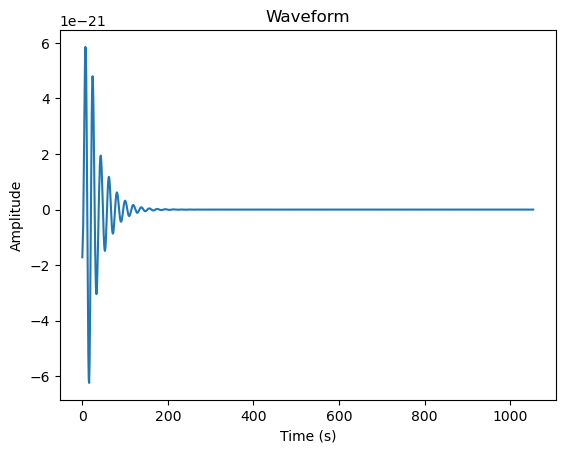

In [1]:

import sys
import os
#import shutil
# 将 `code/Ringdown_gap_filling/Proj/` 添加到 sys.path
proj_dir = os.path.abspath(os.path.join(os.getcwd(), ".."))
if proj_dir not in sys.path:
    sys.path.append(proj_dir)
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
#import bilby
#import corner
from config.config import Config
from data.waveform import *
from data.ringdown_waveform import Gap_dir as Ga




class MyWaveform:
    def __init__(self, samp_freq,Para_dw=para_dw, Para_dtau=para_dtau,  f_in=Config.f_in, f_out=Config.f_out, f_step=Config.f_step):
        self.f_in = f_in
        self.f_out = f_out
        self.f_step = f_step
        self.Para_dw = Para_dw
        self.Para_dtau = Para_dtau
        self.samp_freq = samp_freq

    def __call__(self, **params):
        # 参数处理
        Mtot = params['Mtot']
        M_ratio = params['M_ratio']
        R_shift = params['R_shift']
        
        # 计算参数 
        para1 = [Mtot, M_ratio, R_shift]

        # 频率数组
        freq_ifft = np.arange(self.f_in, self.f_out, self.f_step)

        # 构建频域分量
        f_sf22, f_sf21, f_sf33, f_sf44 = sf_decomposition(freq_ifft, para1, self.Para_dw, self.Para_dtau)
        f_sf = f_sf22 + f_sf21 + f_sf33 + f_sf44

        # 转为时域波形
        st = np.real(Ga.Freq_ifft(f_sf))

        return st
    
def model(**kwargs):
    waveform_generator = kwargs['waveform']  # 类实例
    waveform = waveform_generator(**kwargs)  # 传入其余参数
    return waveform

# 实例化模板生成器
waveform_class = MyWaveform( samp_freq=Config.samp_freq,
    Para_dw=para_dw,
    Para_dtau=para_dtau,
   
    f_in=Config.f_in,
    f_out=Config.f_out,
    f_step=Config.f_step,
    
)

# 生成波形
waveform = model(waveform=waveform_class, Mtot=1.15e5, M_ratio=0.95, R_shift=5)
#绘制波形
plt.plot(waveform[1:Config.signal_length])
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.title('Waveform')
plt.show()


In [3]:
#lisa
import json
import sys
import numpy
from numpy import log, exp, pi,sqrt,cos,sin,abs,log10,abs,e
import scipy.stats, scipy
import pymultinest
import matplotlib.pyplot as plt
#datafile = sys.argv[1]
from utils.psd import PSD_Lisa_no_Response
from utils.noise import fftfilt, stat_gauss_noise,generate_noise_from_psd
#np.loadtxt('./data/GammaT_mean.txt', dtype='complex')
#data = numpy.genfromtxt('htdihltotalls.txt',delimiter=',',dtype='str')
#mapping = numpy.vectorize(lambda t:complex())
#p1= mapping(data)
#beam_data = pd.read_csv("beam1.csv").astype('complex')
#print(data)
'''olds = ['i', '^']
news = ['j', '*']
filename='htdihltotalls.csv'#csv数据为复数
temp = numpy.genfromtxt(filename, delimiter=',',dtype='str')
mapping = numpy.vectorize(lambda t:complex(t.replace(olds,news)))
#mapping = numpy.vectorize(lambda t:complex(t.replace('i','j'),t.replace('^','*')))
p1= mapping(temp)'''

c =2.9979246*1e8
def PSD_Lisa_no_Response(f):
    
    """
    From https://arxiv.org/pdf/1803.01944.pdf. 
    """

    L = 2.5*10**9   # Length of LISA arm
    f0 = c/(2*pi*L)   
    
    Poms = ((1.5*10**-11)**2)*(1 + ((2*10**-3)/f)**4)  # Optical Metrology Sensor
    Pacc = (3*10**-15)**2*(1 + (4*10**-3/(10*f))**2)*(1 + (f/(8*10**-3))**4)  # Acceleration Noise
    Sc = 9*10**(-45)*f**(-7/3)*np.exp(-f**0.171 + 292*f*np.sin(1020*f)) * (1 \
                                            + np.tanh(1680*(0.00215 - f)))   # Confusion noise
    alpha = 0.171
    beta = 292
    k =1020
    gamma = 1680
    f_k = 0.00215 
    PSD = ((1/(L*L))*(Poms + (4*Pacc)/(np.power(2*pi*f,4))) + Sc) # PSD
        
    # Handling the zeroth frequency bin
    
    where_are_NaNs = np.isnan(PSD) 
    PSD[where_are_NaNs] = 1e100    # at f = 0, PSD is infinite. Approximate infinity and burn my 
                                   # mathematics degree to the ground. 
    
    return PSD
scale=Config.scale
samp_freq=Config.samp_freq
freq=np.arange(Config.f_in, Config.f_out, Config.f_step)
PSD=PSD_Lisa_no_Response(freq)
out_noise, _ = generate_noise_from_psd(len(waveform),freq,PSD, sample_rate=samp_freq)

data = waveform + out_noise[0]
Mtot_min=Config.parameters[0]
Mtot_bandwidth=Config.parameters[1]-Config.parameters[0]
Mratio_min=Config.parameters[2]
Mratio_bandwidth=Config.parameters[3]-Config.parameters[2]
Rshift_min=Config.parameters[4]
Rshift_bandwidth=Config.parameters[5]-Config.parameters[4]
def prior(cube, ndim, nparams):
    cube[0] = cube[0]*Mtot_bandwidth+Mtot_min
    cube[1] = cube[1]*Mratio_bandwidth+Mratio_min
    cube[2] = cube[2]*Rshift_bandwidth+Rshift_min

def log_likelihood(cube, data, psd,freq):
    """
    params : dict, e.g., {'M': ..., 'M_ratio': ..., 'R_shift': ...}
    waveform : waveform generator instance, e.g., MyWaveform
    data : time-domain data (signal + noise), 1D numpy array
    psd : PSD array corresponding to positive frequency bins
    samp_freq : sampling rate in Hz
    """
    # 1. 生成模板波形
    M,ratio,redshift= cube[0], cube[1], cube[2]
    h  = model(waveform=waveform_class, Mtot=M, M_ratio=ratio, R_shift=redshift)

    # 2. FFT 到频域
    d_f = np.fft.rfft(data)
    h_f = np.fft.rfft(h)

    # 3. 频率分辨率
    df = freq[1] - freq[0]
    
    PSD=psd(freq)

    # 4. PSD 截断 / 归一化处理（防止除以 0）
    #psd = np.clip(psd, 1e-30, None)

    # 5. 计算差值频谱
    res_f = d_f - h_f

    # 6. 计算内积
    inner_product = 4.0 * np.sum(np.abs(res_f)**2 /PSD) * df

    # 7. 返回对数似然值（忽略常数）
    return -0.5 * inner_product

parameters = ["$M_{tot}/{M_ \odot}$", "$Mass Ratio$","$Red Shift$"]
n_params = len(parameters)


In [ ]:
pymultinest.run(log_likelihood, prior, n_params, outputfiles_basename='test/', resume = False, verbose = True)
json.dump(parameters, open('tdiout2hhh/params.json', 'w'))

'''pymultinest.run(loglike, prior, n_params, outputfiles_basename='out/',
	resume = False, verbose = True)
json.dump(parameters, open('out/params.json', 'w'))'''
plt.figure() 

 *****************************************************
 MultiNest v3.10
 Copyright Farhan Feroz & Mike Hobson
 Release Jul 2015

 no. of live points =  400
 dimensionality =    3
 *****************************************************
 Starting MultiNest
 generating live points


Exception ignored on calling ctypes callback function: <function run.<locals>.loglike at 0x7f74563ba790>
Traceback (most recent call last):
  File "/home/ljq/miniconda3/envs/multinest_env/lib/python3.9/site-packages/pymultinest/run.py", line 223, in loglike
    return LogLikelihood(cube, ndim, nparams, lnew)
  File "/tmp/ipykernel_173827/3206701476.py", line 85, in log_likelihood
  File "/home/ljq/miniconda3/envs/multinest_env/lib/python3.9/site-packages/numpy/fft/_pocketfft.py", line 407, in rfft
    n = a.shape[axis]
IndexError: tuple index out of range
Exception ignored on calling ctypes callback function: <function run.<locals>.loglike at 0x7f74563ba790>
Traceback (most recent call last):
  File "/home/ljq/miniconda3/envs/multinest_env/lib/python3.9/site-packages/pymultinest/run.py", line 223, in loglike
    return LogLikelihood(cube, ndim, nparams, lnew)
  File "/tmp/ipykernel_173827/3206701476.py", line 85, in log_likelihood
  File "/home/ljq/miniconda3/envs/multinest_env/lib/pyt

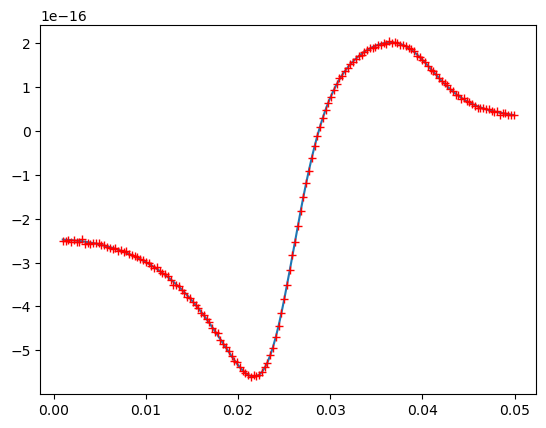

In [12]:
# factor = 10**4
# noise =  sqrt( factor*4*sin(u)**2/L**2 *(sx**2 + sa**2 /(2*pi*f)**4*(3+cos(2*u))))
# hmodel = model(6.5, 0.1, 5, 2/9, 0, pi/3, 0.1)
# data = hmodel + numpy.random.normal(loc=numpy.zeros_like(f), scale=noise, size=None)
plt.plot(f, hmodel.real)
plt.plot(f, data.real, '+', color='r')
#plt.plot(f, noise, '+', color='b')
#plt.yscale('log')
#用loglog绘制


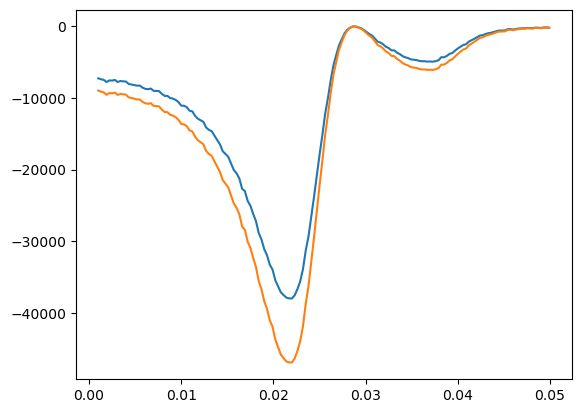

In [ ]:
plt.plot(f,  -0.5 *  ((model(6.5, 0.1, 5, 2/9, 0, pi/3, 0.1).real - data.real) **2/(noise)**2))
plt.plot(f,   -0.5 *  ((model(4, 0.1, 5, 2/9, 0, pi/3, 0.1).real - data.real) **2/(noise)**2))

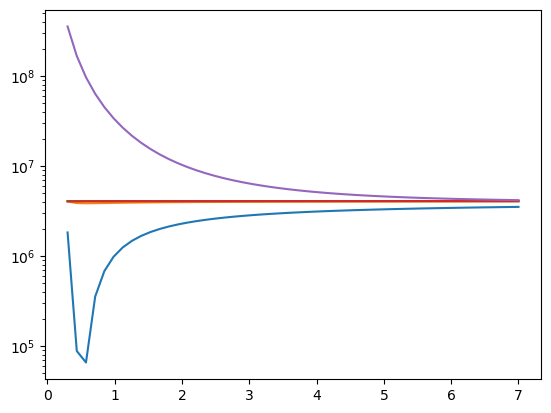

In [ ]:
plt.figure()
xx = numpy.linspace(0.3,7,50)
for j in [6.5,6.2, 5,5.5,7]:
    loglike_sim = numpy.array([ loglike([j, 0.1, xx[i], 2/9, 0, pi/3, 0.1], 7, 7) for i in range(len(xx))] )
    plt.plot(xx,-loglike_sim)
plt.yscale('log')

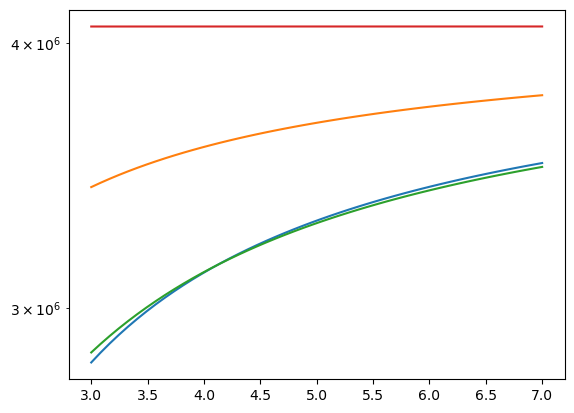

In [ ]:
plt.figure()
xx = numpy.linspace(3,7,50)
for j in [6.5, 6.4, 6.6, 5]:
    loglike_sim = numpy.array([0.5 *  (abs(model(j, 0.1, xx[i], 2/9, 0, pi/3, 0.1) - data) **2/(noise)**2) .sum()  for i in range(len(xx))] )
    plt.plot(xx,loglike_sim)
plt.yscale('log')

Text(0.5, 0.5, 'r')

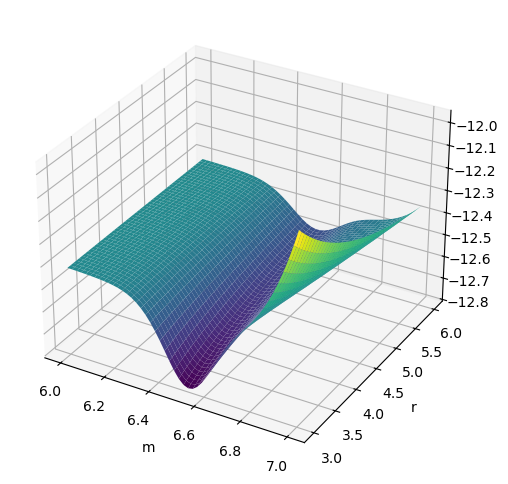

In [ ]:
xx = numpy.linspace(6,7,50)
yy = numpy.linspace(3,6,50)
xxmesh, yymesh = numpy.meshgrid(xx,yy)
loglike_sim = numpy.array([[0.5 * (abs(model(xx[i], 0.01,yy[j],2/9,0,pi/3,0.2) - data )**2/(10**6*noise)**2 ).sum()   for i in range(len(xx))] for j in range(len(yy))])
#[(-0.5 * abs((model(xx[i], 0.01,0.5,2/9,0,pi/3,0.2) - data) / (10**10*noise))**2).sum() for i in range(30)]
#loglikelihood = (-0.5 * abs((model(xx[i], 0.01,0.5,2/9,0,pi/3,0.2) - data) / (10**10*noise))**2).sum()
fig = plt.figure(figsize=(12,6))
ax = plt.axes(projection='3d')
# lvlt = np.logspace(-2,-1,11)
# ax.contour3D(xxmesh, yymesh, loglike_sim)
ax.plot_surface(xxmesh, yymesh, log(loglike_sim), cmap='viridis')
ax.set_xlabel('m')
ax.set_ylabel('r')
# plt.yscale('log')

In [ ]:
# xx = numpy.linspace(5,7,50)
# yy = numpy.linspace(1,6,50)
# xxmesh, yymesh = numpy.meshgrid(xx,yy)
# loglike_sim = numpy.array([[0.5 * (abs(model(xx[i], 0.01,yy[j],2/9,0,pi/3,0.2) - data )**2/(10**6*noise)**2 ).sum()   for i in range(len(xx))] for j in range(len(yy))])
# #[(-0.5 * abs((model(xx[i], 0.01,0.5,2/9,0,pi/3,0.2) - data) / (10**10*noise))**2).sum() for i in range(30)]
# #loglikelihood = (-0.5 * abs((model(xx[i], 0.01,0.5,2/9,0,pi/3,0.2) - data) / (10**10*noise))**2).sum()
# fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(8, 5))
# # ax = plt.axes(projection='3d')
# # lvlt = np.logspace(-2,-1,11)
# # ax.contour3D(xxmesh, yymesh, loglike_sim)
# ax.contour(xxmesh, yymesh, log(loglike_sim), cmap='viridis')
# ax.plot([6.5], [5], "s")
# ax.set_xlabel('m')
# ax.set_ylabel('r')
# # plt.yscale('log')

: 

In [ ]:

# run MultiNest
pymultinest.run(loglike, prior, n_params, outputfiles_basename='tdiout2hhh/', resume = False, verbose = True)
json.dump(parameters, open('tdiout2hhh/params.json', 'w'))

'''pymultinest.run(loglike, prior, n_params, outputfiles_basename='out/',
	resume = False, verbose = True)
json.dump(parameters, open('out/params.json', 'w'))'''
plt.figure() 
plt.plot(f, data, '+ ', color='red', label='data')
a = pymultinest.Analyzer(outputfiles_basename='tdiout2hhh/', n_params = n_params)
for (m, a,R,v,Phi,x,b) in a.get_equal_weighted_posterior()[::100,:-1]:
	plt.plot(f, model(m, a,R,v,Phi,x,b), '-', color='blue', alpha=0.3, label='data')

#plt.savefig('out2/posterior.pdf')
#a_lnZ = a.get_stats()['global evidence']

  analysing data from tdiout3hh/.txt
  analysing data from tditqout3hh/.txt
  analysing data from tditjout3h/.txt


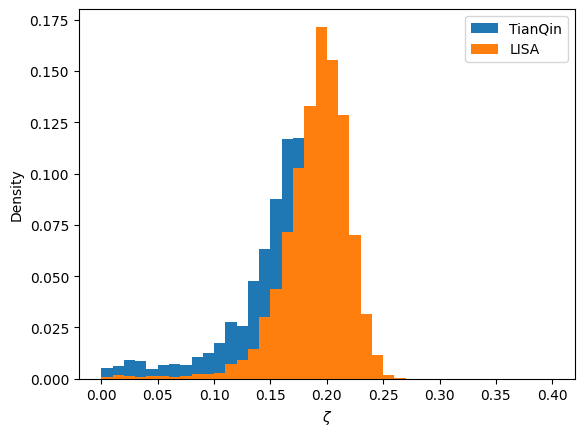

In [ ]:
a = pymultinest.Analyzer(n_params = n_params, outputfiles_basename = 'tdiout3hh/')
d = pymultinest.Analyzer(n_params = n_params, outputfiles_basename = 'tditqout3hh/')#'tditqout3h/'
tj = pymultinest.Analyzer(n_params = n_params, outputfiles_basename = 'tditjout3h/')
s = a.get_stats()
s1 = d.get_stats()
s2 = tj.get_stats()
data = a.get_data()[:,2:]
data1 = d.get_data()[:,2:]
data2 = tj.get_data()[:,2:]
weights = a.get_data()[:,0]
weights1 = d.get_data()[:,0]
weights2 = tj.get_data()[:,0]
#data[:,-1]
fig, axes = plt.subplots(1, 1)
axes.hist(data1[:,-1],bins=40,weights=weights1,range=[0, 0.4], label='TianQin')
axes.hist(data[:,-1],bins=40,weights=weights,range=[0, 0.4], label='LISA')
#axes.hist(data2[:,-1],bins=40,weights=weights2,range=[0, 0.4], label='TaiJi')


#plt.title('Legend Example 2')
plt.xlabel("$\zeta $")
plt.ylabel('Density')
plt.legend()
plt.savefig('tdi2/'+ 'snr2.pdf' )
plt.show()

  analysing data from tdiout2h/.txt
  analysing data from tditqout2h/.txt
  analysing data from tditjout2h/.txt


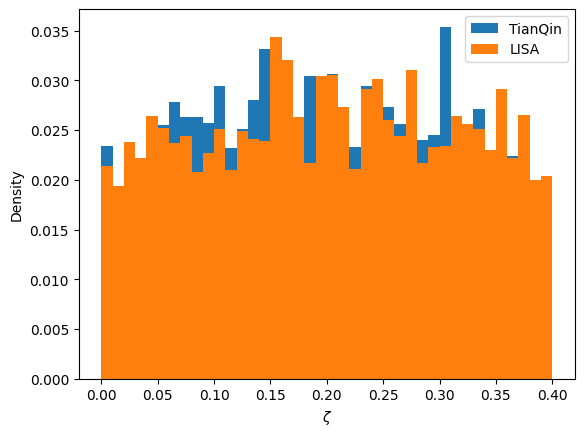

In [ ]:
a = pymultinest.Analyzer(n_params = n_params, outputfiles_basename = 'tdiout2h/')
d = pymultinest.Analyzer(n_params = n_params, outputfiles_basename = 'tditqout2h/')
tj = pymultinest.Analyzer(n_params = n_params, outputfiles_basename = 'tditjout2h/')
s = a.get_stats()
s1 = d.get_stats()
s2 = tj.get_stats()
data = a.get_data()[:,2:]
data1 = d.get_data()[:,2:]
data2 = tj.get_data()[:,2:]
weights = a.get_data()[:,0]
weights1 = d.get_data()[:,0]
weights2 = tj.get_data()[:,0]
#data[:,-1]
fig, axes = plt.subplots(1, 1)
'''axes.hist(data[:,-1],bins=40,weights=weights,range=[0, 0.25], label='LISA,$\zeta=0.15_{-0.08}^{+0.07}$')
axes.hist(data2[:,-1],bins=40,weights=weights2,range=[0, 0.25], label='TaiJi,$\zeta=0.12_{-0.07}^{+0.09}$')
axes.hist(data1[:,-1],bins=40,weights=weights1,range=[0, 0.25], label='TianQin,$\zeta=0.15_{-0.08}^{+0.07}$')'''
axes.hist(data1[:,-1],bins=40,weights=weights1,range=[0, 0.4], label='TianQin')
axes.hist(data[:,-1],bins=40,weights=weights,range=[0, 0.4], label='LISA')
#axes.hist(data2[:,-1],bins=40,weights=weights2,range=[0, 0.4], label='TaiJi')
#plt.title('Legend Example 2')
plt.xlabel("$\zeta $")
plt.ylabel('Density')
plt.legend()
plt.savefig('tdi2/'+ 'snr1.pdf' )
plt.show()

In [ ]:
from __future__ import absolute_import, unicode_literals, print_function

import numpy
from numpy import exp, log
import matplotlib.pyplot as plt
import sys, os
import json
import pymultinest
import corner
prefix = 'tdiout3/'

parameters = json.load(open(prefix + 'params.json'))
#parameters = ["$\\log\\Omega^T_0$", "$\\log\\Omega^V_0$", "$\\log\\Omega^B_0$", "$\\log\\Omega^L_0$", "$\\alpha_T$", "$\\alpha_V$", "$\\alpha_B$", "$\\alpha_L$"]
n_params = len(parameters)

a = pymultinest.Analyzer(n_params = n_params, outputfiles_basename = prefix)
s = a.get_stats()

json.dump(s, open(prefix + 'stats.json', 'w'), indent=4)

# print('  marginal likelihood:')
# print('    ln Z = %.1f +- %.1f' % (s['global evidence'], s['global evidence error']))
# print('  parameters:')
# for p, m in zip(parameters, s['marginals']):
# 	lo, hi = m['1sigma']
# 	med = m['median']
# 	sigma = (hi - lo) / 2
# 	if sigma == 0:
# 		i = 3
# 	else:
# 		i = max(0, int(-numpy.floor(numpy.log10(sigma))) + 1)
# 	fmt = '%%.%df' % i
# 	fmts = '\t'.join(['    %-15s' + fmt + " +- " + fmt])
# 	print(fmts % (p, med, sigma))

print('creating marginal plot ...')
data1 = a.get_data()[:,2:]
weights = a.get_data()[:,0]

#mask = weights.cumsum() > 1e-5
# mask = weights > 1e-4
mask = weights > 1e-40
#  -10.55 -10.54 -10.17 -10.47
#truths = [-11.07, None, -10.76, None, 0.667 , None, 0.667, None]
# truths = [-11.07, -11.12, None, None, 0.667, 0.667, None, None]
color = ['b', 'g', 'orange', 'r', 'b', 'g', 'orange', 'r', '#8A2BE2']
myrange = [(6, 7), (0.001, 0.26), (3, 12), (0, 0.25), (0, 2*pi), (0, pi), (0, 0.5)]
corner.corner(data1[mask,:], weights=weights[mask], bins=60, hist_bin_factor = 0.4, histtype='bar',
	labels=parameters, color=color, show_titles=True, range=myrange, plot_contours=False, truth_color='k', plot_datapoints=False)


  analysing data from tdiout3/.txt


ValueError: could not convert string '-0.689151062899564466-315' to float64 at row 0, column 2.

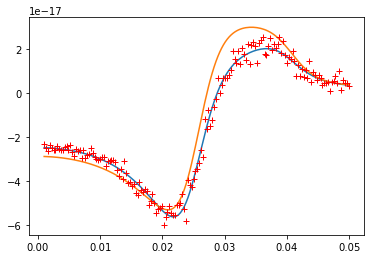

In [ ]:
plt.plot(f, model(6.5, 0.1, 5, 2/9, 0, pi/3, 0.1).real)
plt.plot(f, model(6.5, 0.15, 4.23, 0.13, 0.1, 0.53, 0.16).real)
plt.plot(f, data.real, '+', color='r')

In [ ]:
##天琴
import json
import sys
import numpy
from numpy import log, exp, pi,sqrt,cos,sin,abs
import scipy.stats, scipy
import pymultinest
import matplotlib.pyplot as plt
#datafile = sys.argv[1]
data = numpy.loadtxt('htdihltotaltq.txt')
#print(data)
Ms = 1.99*10**30
pc = 3.26*9.46*10**15
c = 3*10**8
cG = 6.67*10**-11
def A1(v):
    return 0.864*v

def  A3(v):
    return 0.44*(1 - 4*v)**0.45*A1(v)
#print(A3(0.1))

def  w1(m,b,a):
  return ((0.3736*(1 - 0.03135*b**2 - 0.09674*b**3 + 0.2375*b**4) + 
   2*a*(0.0629 - 0.0156*b**2 - 0.00758*b**3 - 0.0644*b**4 + 0.268*b**5 - 
      0.603*b**6))*c**3)/(cG*((10**m)*Ms))
#print(w1(1.99*10**36,0.1,0.01))  
def  tau1(m,b,a):
  return 1/((((0.0888)*(1 + 0.04371*b**2 + 0.1794*b**3 - 0.2947*b**4) + 
      2*a*(0.00099 - 0.0011*b**2 + 0.01864*b**3 - 0.17271*b**4 + 
         0.56422*b**5 - 0.8119*b**6))*c**3)/(cG*((10**m)*Ms)))
#print(tau1(1.99*10**36,0.1,0.01)) 
def  w3(m,b,a):
     return ((0.5994*(1 - 0.09911*b**2 - 0.04907*b**3 + 0.09286*b**4) + 
   3*a*(0.0674 - 0.0291*b**2 + 0.0251*b**3 - 0.3209*b**4 + 1.1703*b**5 - 
      1.3341*b**6))*c**3)/(cG*((10**m)*Ms))
#print(w3(1.99*10**36,0.1,0.01))
def  tau3(m,b,a):
  return 1/((((0.0927)*(1 + 0.07710*b**2 + 0.1399*b**3 - 0.3450*b**4) + 
     3*a*(0.00065 + 0.00023*b**2 + 0.0233*b**3 - 0.2832*b**4 + 
        1.323*b**5 - 2.442*b**6))*c**3)/(cG*((10**m)*Ms)))
#print(tau3(1.99*10**36,0.1,0.01))
Psi=pi/3
Phi0=0
Theta=0
t0=0
'''fa=[0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1, 0.11, \
0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2, 0.21, 0.22, \
0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.3, 0.31, 0.32, 0.33, \
0.34, 0.35, 0.36, 0.37, 0.38, 0.39, 0.4, 0.41, 0.42, 0.43, 0.44, \
0.45, 0.46, 0.47, 0.48, 0.49, 0.5, 0.51, 0.52, 0.53, 0.54, 0.55, \
0.56, 0.57, 0.58, 0.59, 0.6, 0.61, 0.62, 0.63, 0.64, 0.65, 0.66, \
0.67, 0.68, 0.69, 0.7, 0.71, 0.72, 0.73, 0.74, 0.75, 0.76, 0.77, \
0.78, 0.79, 0.8, 0.81, 0.82, 0.83, 0.84, 0.85, 0.86, 0.87, 0.88, \
0.89, 0.9, 0.91, 0.92, 0.93, 0.94, 0.95, 0.96, 0.97, 0.98, 0.99, 1]'''
fa=numpy.loadtxt('f.txt')
f=numpy.array(fa)
#print(f)

'''def model(M, v, x, t0,Phi,a,b,r):
  h=cG*M*sqrt(5/pi)*A1(v)*cos(x)*cos(Theta)*cos(2*Psi)*sin(2*Phi0)\
   *(((-cos(f*t0 + 2*Phi)*1j + sin(f*t0 + 2*Phi))*1j*tau1(M,b,a))/(2*sqrt(2*pi)*(1j+f*tau1(M,b,a)-tau1(M,b,a)*w1(M,b,a)))\
   -((cos(f*t0 - 2*Phi) + sin(f*t0 - 2*Phi)*1j)*tau1(M,b,a))/(2*sqrt(2*pi)*(1j + f*tau1(M,b,a) + tau1(M,b,a)*w1(M,b,a))))/(2*c**2*r)\
   +cG*M*sqrt(5/pi)*A1(v)*cos(x)*cos(2*Phi0)*sin(2*Psi)\
   *(((-cos(f*t0 + 2*Phi)*1j + sin(f*t0 + 2*Phi))*1j*tau1(M,b,a))/(2*sqrt(2*pi)*(1j+f*tau1(M,b,a)-tau1(M,b,a)*w1(M,b,a)))\
   -((cos(f*t0 - 2*Phi) + sin(f*t0 - 2*Phi)*1j)*tau1(M,b,a))/(2*sqrt(2*pi)*(1j + f*tau1(M,b,a) + tau1(M,b,a)*w1(M,b,a))))/(4*c**2*r)\
   +cG*M*sqrt(5/pi)*A1(v)*cos(x)*cos(Theta)**2*cos(2*Phi0)*sin(2*Psi)\
   *(((-cos(f*t0 + 2*Phi)*1j + sin(f*t0 + 2*Phi))*1j*tau1(M,b,a))/(2*sqrt(2*pi)*(1j+f*tau1(M,b,a)-tau1(M,b,a)*w1(M,b,a)))\
   -((cos(f*t0 - 2*Phi) + sin(f*t0 - 2*Phi)*1j)*tau1(M,b,a))/(2*sqrt(2*pi)*(1j + f*tau1(M,b,a) + tau1(M,b,a)*w1(M,b,a))))/(4*c**2*r)\
   +cG*M*sqrt(5/pi)*A1(v)*cos(2*Phi0)*cos(2*Psi)\
   *(((cos(f*t0 + 2*Phi) + sin(f*t0 + 2*Phi)*1j)*1j*tau1(M,b,a))/(2*sqrt(2*pi)*(1j+f*tau1(M,b,a)-tau1(M,b,a)*w1(M,b,a)))\
   +((cos(f*t0 - 2*Phi) + sin(f*t0 - 2*Phi)*1j)*1j*tau1(M,b,a))/(2*sqrt(2*pi)*(1j + f*tau1(M,b,a) + tau1(M,b,a)*w1(M,b,a))))/(8*c**2*r)\
   +cG*M*sqrt(5/pi)*A1(v)*cos(x)**2*cos(2*Phi0)*cos(2*Psi)\
   *(((cos(f*t0 + 2*Phi) + sin(f*t0 + 2*Phi)*1j)*1j*tau1(M,b,a))/(2*sqrt(2*pi)*(1j+f*tau1(M,b,a)-tau1(M,b,a)*w1(M,b,a)))\
   +((cos(f*t0 - 2*Phi) + sin(f*t0 - 2*Phi)*1j)*1j*tau1(M,b,a))/(2*sqrt(2*pi)*(1j + f*tau1(M,b,a) + tau1(M,b,a)*w1(M,b,a))))/(8*c**2*r)\
   +cG*M*sqrt(5/pi)*A1(v)*cos(Theta)**2*cos(2*Phi0)*cos(2*Psi)\
   *(((cos(f*t0 + 2*Phi) + sin(f*t0 + 2*Phi)*1j)*1j*tau1(M,b,a))/(2*sqrt(2*pi)*(1j+f*tau1(M,b,a)-tau1(M,b,a)*w1(M,b,a)))\
   +((cos(f*t0 - 2*Phi) + sin(f*t0 - 2*Phi)*1j)*1j*tau1(M,b,a))/(2*sqrt(2*pi)*(1j + f*tau1(M,b,a) + tau1(M,b,a)*w1(M,b,a))))/(8*c**2*r)\
   +cG*M*sqrt(5/pi)*A1(v)*cos(x)**2*cos(Theta)**2*cos(2*Phi0)*cos(2*Psi)\
   *(((cos(f*t0 + 2*Phi) + sin(f*t0 + 2*Phi)*1j)*1j*tau1(M,b,a))/(2*sqrt(2*pi)*(1j+f*tau1(M,b,a)-tau1(M,b,a)*w1(M,b,a)))\
   +((cos(f*t0 - 2*Phi) + sin(f*t0 - 2*Phi)*1j)*1j*tau1(M,b,a))/(2*sqrt(2*pi)*(1j + f*tau1(M,b,a) + tau1(M,b,a)*w1(M,b,a))))/(8*c**2*r)\
   -cG*M*sqrt(5/pi)*A1(v)*cos(Theta)*cos(Phi0)*cos(Psi)*sin(Phi0)*sin(Psi)\
   *(((cos(f*t0 + 2*Phi) + sin(f*t0 + 2*Phi)*1j)*1j*tau1(M,b,a))/(2*sqrt(2*pi)*(1j+f*tau1(M,b,a)-tau1(M,b,a)*w1(M,b,a)))\
   +((cos(f*t0 - 2*Phi) + sin(f*t0 - 2*Phi)*1j)*1j*tau1(M,b,a))/(2*sqrt(2*pi)*(1j + f*tau1(M,b,a) + tau1(M,b,a)*w1(M,b,a))))/(c**2*r)\
   -cG*M*sqrt(5/pi)*A1(v)*cos(x)**2*cos(Theta)*cos(Phi0)*cos(Psi)*sin(Phi0)*sin(Psi)\
   *(((cos(f*t0 + 2*Phi) + sin(f*t0 + 2*Phi)*1j)*1j*tau1(M,b,a))/(2*sqrt(2*pi)*(1j+f*tau1(M,b,a)-tau1(M,b,a)*w1(M,b,a)))\
   +((cos(f*t0 - 2*Phi) + sin(f*t0 - 2*Phi)*1j)*1j*tau1(M,b,a))/(2*sqrt(2*pi)*(1j + f*tau1(M,b,a) + tau1(M,b,a)*w1(M,b,a))))/(c**2*r)\
   -cG*M*sqrt(21/(2*pi))*A3(v)*cos(x)*cos(Theta)*cos(2*Psi)*sin(x)*sin(2*Phi0)\
   *(((-cos(f*t0 + 3*Phi)*1j + sin(f*t0 + 3*Phi))*1j*tau3(M,b,a))/(2*sqrt(2*pi)*(1j+f*tau3(M,b,a)-tau3(M,b,a)*w3(M,b,a)))\
   -((cos(f*t0 - 3*Phi) + sin(f*t0 - 3*Phi)*1j)*tau3(M,b,a))/(2*sqrt(2*pi)*(1j + f*tau3(M,b,a) + tau3(M,b,a)*w3(M,b,a))))/(2*c**2*r)\
   -cG*M*sqrt(21/(2*pi))*A3(v)*cos(x)*cos(2*Phi0)*sin(x)*sin(2*Psi)\
   *(((-cos(f*t0 + 3*Phi)*1j + sin(f*t0 + 3*Phi))*1j*tau3(M,b,a))/(2*sqrt(2*pi)*(1j+f*tau3(M,b,a)-tau3(M,b,a)*w3(M,b,a)))\
   -((cos(f*t0 - 3*Phi) + sin(f*t0 - 3*Phi)*1j)*tau3(M,b,a))/(2*sqrt(2*pi)*(1j + f*tau3(M,b,a) + tau3(M,b,a)*w3(M,b,a))))/(4*c**2*r)\
   -cG*M*sqrt(21/(2*pi))*A3(v)*cos(x)*cos(Theta)**2*cos(2*Phi0)*sin(x)*sin(2*Psi)\
   *(((-cos(f*t0 + 3*Phi)*1j + sin(f*t0 + 3*Phi))*1j*tau3(M,b,a))/(2*sqrt(2*pi)*(1j+f*tau3(M,b,a)-tau3(M,b,a)*w3(M,b,a)))\
   -((cos(f*t0 - 3*Phi) + sin(f*t0 - 3*Phi)*1j)*tau3(M,b,a))/(2*sqrt(2*pi)*(1j + f*tau3(M,b,a) + tau3(M,b,a)*w3(M,b,a))))/(4*c**2*r)\
   -cG*M*sqrt(21/(2*pi))*A3(v)*cos(2*Phi0)*cos(2*Psi)*sin(x)\
   *(((cos(f*t0 + 3*Phi) + sin(f*t0 + 3*Phi)*1j)*1j*tau3(M,b,a))/(2*sqrt(2*pi)*(1j+f*tau3(M,b,a)-tau3(M,b,a)*w3(M,b,a)))\
   +((cos(f*t0 - 3*Phi) + sin(f*t0 - 3*Phi)*1j)*1j*tau3(M,b,a))/(2*sqrt(2*pi)*(1j + f*tau3(M,b,a) + tau3(M,b,a)*w3(M,b,a))))/(8*c**2*r)\
   -cG*M*sqrt(21/(2*pi))*A3(v)*cos(x)**2*cos(2*Phi0)*cos(2*Psi)*sin(x)\
   *(((cos(f*t0 + 3*Phi) + sin(f*t0 + 3*Phi)*1j)*1j*tau3(M,b,a))/(2*sqrt(2*pi)*(1j+f*tau3(M,b,a)-tau3(M,b,a)*w3(M,b,a)))\
   +((cos(f*t0 - 3*Phi) + sin(f*t0 - 3*Phi)*1j)*1j*tau3(M,b,a))/(2*sqrt(2*pi)*(1j + f*tau3(M,b,a) + tau3(M,b,a)*w3(M,b,a))))/(8*c**2*r)\
   -cG*M*sqrt(21/(2*pi))*A3(v)*cos(Theta)**2*cos(2*Phi0)*cos(2*Psi)*sin(x)\
   *(((cos(f*t0 + 3*Phi) + sin(f*t0 + 3*Phi)*1j)*1j*tau3(M,b,a))/(2*sqrt(2*pi)*(1j+f*tau3(M,b,a)-tau3(M,b,a)*w3(M,b,a)))\
   +((cos(f*t0 - 3*Phi) + sin(f*t0 - 3*Phi)*1j)*1j*tau3(M,b,a))/(2*sqrt(2*pi)*(1j + f*tau3(M,b,a) + tau3(M,b,a)*w3(M,b,a))))/(8*c**2*r)\
   -cG*M*sqrt(21/(2*pi))*A3(v)*cos(x)**2*cos(Theta)**2*cos(2*Phi0)*cos(2*Psi)*sin(x)\
   *(((cos(f*t0 + 3*Phi) + sin(f*t0 + 3*Phi)*1j)*1j*tau3(M,b,a))/(2*sqrt(2*pi)*(1j+f*tau3(M,b,a)-tau3(M,b,a)*w3(M,b,a)))\
   +((cos(f*t0 - 3*Phi) + sin(f*t0 - 3*Phi)*1j)*1j*tau3(M,b,a))/(2*sqrt(2*pi)*(1j + f*tau3(M,b,a) + tau3(M,b,a)*w3(M,b,a))))/(8*c**2*r)\
   +cG*M*sqrt(21/(2*pi))*A3(v)*cos(Theta)*cos(Phi0)*cos(Psi)*sin(x)*sin(Phi0)*sin(Psi)\
   *(((cos(f*t0 + 3*Phi) + sin(f*t0 + 3*Phi)*1j)*1j*tau3(M,b,a))/(2*sqrt(2*pi)*(1j+f*tau3(M,b,a)-tau3(M,b,a)*w3(M,b,a)))\
   +((cos(f*t0 - 3*Phi) + sin(f*t0 - 3*Phi)*1j)*1j*tau3(M,b,a))/(2*sqrt(2*pi)*(1j + f*tau3(M,b,a) + tau3(M,b,a)*w3(M,b,a))))/(c**2*r)\
   +cG*M*sqrt(21/(2*pi))*A3(v)*cos(x)**2*cos(Theta)*cos(Phi0)*cos(Psi)*sin(x)*sin(Phi0)*sin(Psi)\
   *(((cos(f*t0 + 3*Phi) + sin(f*t0 + 3*Phi)*1j)*1j*tau3(M,b,a))/(2*sqrt(2*pi)*(1j+f*tau3(M,b,a)-tau3(M,b,a)*w3(M,b,a)))\
   +((cos(f*t0 - 3*Phi) + sin(f*t0 - 3*Phi)*1j)*1j*tau3(M,b,a))/(2*sqrt(2*pi)*(1j + f*tau3(M,b,a) + tau3(M,b,a)*w3(M,b,a))))/(c**2*r)
  return h'''
# model(m, a,R,v,t0,Phi,x,b):
def model(m, a,R,v,Phi,x,b):
  h=cG*(10**m)*Ms*sqrt(5/pi)*A1(v)*cos(x)*cos(Theta)*cos(2*Psi)*sin(2*Phi0)\
   *(((-cos(f*t0 + 2*Phi)*1j + sin(f*t0 + 2*Phi))*1j*tau1(m,b,a))/(2*sqrt(2*pi)*(1j+f*tau1(m,b,a)-tau1(m,b,a)*w1(m,b,a)))\
   -((cos(f*t0 - 2*Phi) + sin(f*t0 - 2*Phi)*1j)*tau1(m,b,a))/(2*sqrt(2*pi)*(1j + f*tau1(m,b,a) + tau1(m,b,a)*w1(m,b,a))))/(2*c**2*R*10**9*pc)\
   +cG*(10**m)*Ms*sqrt(5/pi)*A1(v)*cos(x)*cos(2*Phi0)*sin(2*Psi)\
   *(((-cos(f*t0 + 2*Phi)*1j + sin(f*t0 + 2*Phi))*1j*tau1(m,b,a))/(2*sqrt(2*pi)*(1j+f*tau1(m,b,a)-tau1(m,b,a)*w1(m,b,a)))\
   -((cos(f*t0 - 2*Phi) + sin(f*t0 - 2*Phi)*1j)*tau1(m,b,a))/(2*sqrt(2*pi)*(1j + f*tau1(m,b,a) + tau1(m,b,a)*w1(m,b,a))))/(4*c**2*R*10**9*pc)\
   +cG*(10**m)*Ms*sqrt(5/pi)*A1(v)*cos(x)*cos(Theta)**2*cos(2*Phi0)*sin(2*Psi)\
   *(((-cos(f*t0 + 2*Phi)*1j + sin(f*t0 + 2*Phi))*1j*tau1(m,b,a))/(2*sqrt(2*pi)*(1j+f*tau1(m,b,a)-tau1(m,b,a)*w1(m,b,a)))\
   -((cos(f*t0 - 2*Phi) + sin(f*t0 - 2*Phi)*1j)*tau1(m,b,a))/(2*sqrt(2*pi)*(1j + f*tau1(m,b,a) + tau1(m,b,a)*w1(m,b,a))))/(4*c**2*R*10**9*pc)\
   +cG*(10**m)*Ms*sqrt(5/pi)*A1(v)*cos(2*Phi0)*cos(2*Psi)\
   *(((cos(f*t0 + 2*Phi) + sin(f*t0 + 2*Phi)*1j)*1j*tau1(m,b,a))/(2*sqrt(2*pi)*(1j+f*tau1(m,b,a)-tau1(m,b,a)*w1(m,b,a)))\
   +((cos(f*t0 - 2*Phi) + sin(f*t0 - 2*Phi)*1j)*1j*tau1(m,b,a))/(2*sqrt(2*pi)*(1j + f*tau1(m,b,a) + tau1(m,b,a)*w1(m,b,a))))/(8*c**2*R*10**9*pc)\
   +cG*(10**m)*Ms*sqrt(5/pi)*A1(v)*cos(x)**2*cos(2*Phi0)*cos(2*Psi)\
   *(((cos(f*t0 + 2*Phi) + sin(f*t0 + 2*Phi)*1j)*1j*tau1(m,b,a))/(2*sqrt(2*pi)*(1j+f*tau1(m,b,a)-tau1(m,b,a)*w1(m,b,a)))\
   +((cos(f*t0 - 2*Phi) + sin(f*t0 - 2*Phi)*1j)*1j*tau1(m,b,a))/(2*sqrt(2*pi)*(1j + f*tau1(m,b,a) + tau1(m,b,a)*w1(m,b,a))))/(8*c**2*R*10**9*pc)\
   +cG*(10**m)*Ms*sqrt(5/pi)*A1(v)*cos(Theta)**2*cos(2*Phi0)*cos(2*Psi)\
   *(((cos(f*t0 + 2*Phi) + sin(f*t0 + 2*Phi)*1j)*1j*tau1(m,b,a))/(2*sqrt(2*pi)*(1j+f*tau1(m,b,a)-tau1(m,b,a)*w1(m,b,a)))\
   +((cos(f*t0 - 2*Phi) + sin(f*t0 - 2*Phi)*1j)*1j*tau1(m,b,a))/(2*sqrt(2*pi)*(1j + f*tau1(m,b,a) + tau1(m,b,a)*w1(m,b,a))))/(8*c**2*R*10**9*pc)\
   +cG*(10**m)*Ms*sqrt(5/pi)*A1(v)*cos(x)**2*cos(Theta)**2*cos(2*Phi0)*cos(2*Psi)\
   *(((cos(f*t0 + 2*Phi) + sin(f*t0 + 2*Phi)*1j)*1j*tau1(m,b,a))/(2*sqrt(2*pi)*(1j+f*tau1(m,b,a)-tau1(m,b,a)*w1(m,b,a)))\
   +((cos(f*t0 - 2*Phi) + sin(f*t0 - 2*Phi)*1j)*1j*tau1(m,b,a))/(2*sqrt(2*pi)*(1j + f*tau1(m,b,a) + tau1(m,b,a)*w1(m,b,a))))/(8*c**2*R*10**9*pc)\
   -cG*(10**m)*Ms*sqrt(5/pi)*A1(v)*cos(Theta)*cos(Phi0)*cos(Psi)*sin(Phi0)*sin(Psi)\
   *(((cos(f*t0 + 2*Phi) + sin(f*t0 + 2*Phi)*1j)*1j*tau1(m,b,a))/(2*sqrt(2*pi)*(1j+f*tau1(m,b,a)-tau1(m,b,a)*w1(m,b,a)))\
   +((cos(f*t0 - 2*Phi) + sin(f*t0 - 2*Phi)*1j)*1j*tau1(m,b,a))/(2*sqrt(2*pi)*(1j + f*tau1(m,b,a) + tau1(m,b,a)*w1(m,b,a))))/(c**2*R*10**9*pc)\
   -cG*(10**m)*Ms*sqrt(5/pi)*A1(v)*cos(x)**2*cos(Theta)*cos(Phi0)*cos(Psi)*sin(Phi0)*sin(Psi)\
   *(((cos(f*t0 + 2*Phi) + sin(f*t0 + 2*Phi)*1j)*1j*tau1(m,b,a))/(2*sqrt(2*pi)*(1j+f*tau1(m,b,a)-tau1(m,b,a)*w1(m,b,a)))\
   +((cos(f*t0 - 2*Phi) + sin(f*t0 - 2*Phi)*1j)*1j*tau1(m,b,a))/(2*sqrt(2*pi)*(1j + f*tau1(m,b,a) + tau1(m,b,a)*w1(m,b,a))))/(c**2*R*10**9*pc)\
   -cG*(10**m)*Ms*sqrt(21/(2*pi))*A3(v)*cos(x)*cos(Theta)*cos(2*Psi)*sin(x)*sin(2*Phi0)\
   *(((-cos(f*t0 + 3*Phi)*1j + sin(f*t0 + 3*Phi))*1j*tau3(m,b,a))/(2*sqrt(2*pi)*(1j+f*tau3(m,b,a)-tau3(m,b,a)*w3(m,b,a)))\
   -((cos(f*t0 - 3*Phi) + sin(f*t0 - 3*Phi)*1j)*tau3(m,b,a))/(2*sqrt(2*pi)*(1j + f*tau3(m,b,a) + tau3(m,b,a)*w3(m,b,a))))/(2*c**2*R*10**9*pc)\
   -cG*(10**m)*Ms*sqrt(21/(2*pi))*A3(v)*cos(x)*cos(2*Phi0)*sin(x)*sin(2*Psi)\
   *(((-cos(f*t0 + 3*Phi)*1j + sin(f*t0 + 3*Phi))*1j*tau3(m,b,a))/(2*sqrt(2*pi)*(1j+f*tau3(m,b,a)-tau3(m,b,a)*w3(m,b,a)))\
   -((cos(f*t0 - 3*Phi) + sin(f*t0 - 3*Phi)*1j)*tau3(m,b,a))/(2*sqrt(2*pi)*(1j + f*tau3(m,b,a) + tau3(m,b,a)*w3(m,b,a))))/(4*c**2*R*10**9*pc)\
   -cG*(10**m)*Ms*sqrt(21/(2*pi))*A3(v)*cos(x)*cos(Theta)**2*cos(2*Phi0)*sin(x)*sin(2*Psi)\
   *(((-cos(f*t0 + 3*Phi)*1j + sin(f*t0 + 3*Phi))*1j*tau3(m,b,a))/(2*sqrt(2*pi)*(1j+f*tau3(m,b,a)-tau3(m,b,a)*w3(m,b,a)))\
   -((cos(f*t0 - 3*Phi) + sin(f*t0 - 3*Phi)*1j)*tau3(m,b,a))/(2*sqrt(2*pi)*(1j + f*tau3(m,b,a) + tau3(m,b,a)*w3(m,b,a))))/(4*c**2*R*10**9*pc)\
   -cG*(10**m)*Ms*sqrt(21/(2*pi))*A3(v)*cos(2*Phi0)*cos(2*Psi)*sin(x)\
   *(((cos(f*t0 + 3*Phi) + sin(f*t0 + 3*Phi)*1j)*1j*tau3(m,b,a))/(2*sqrt(2*pi)*(1j+f*tau3(m,b,a)-tau3(m,b,a)*w3(m,b,a)))\
   +((cos(f*t0 - 3*Phi) + sin(f*t0 - 3*Phi)*1j)*1j*tau3(m,b,a))/(2*sqrt(2*pi)*(1j + f*tau3(m,b,a) + tau3(m,b,a)*w3(m,b,a))))/(8*c**2*R*10**9*pc)\
   -cG*(10**m)*Ms*sqrt(21/(2*pi))*A3(v)*cos(x)**2*cos(2*Phi0)*cos(2*Psi)*sin(x)\
   *(((cos(f*t0 + 3*Phi) + sin(f*t0 + 3*Phi)*1j)*1j*tau3(m,b,a))/(2*sqrt(2*pi)*(1j+f*tau3(m,b,a)-tau3(m,b,a)*w3(m,b,a)))\
   +((cos(f*t0 - 3*Phi) + sin(f*t0 - 3*Phi)*1j)*1j*tau3(m,b,a))/(2*sqrt(2*pi)*(1j + f*tau3(m,b,a) + tau3(m,b,a)*w3(m,b,a))))/(8*c**2*R*10**9*pc)\
   -cG*(10**m)*Ms*sqrt(21/(2*pi))*A3(v)*cos(Theta)**2*cos(2*Phi0)*cos(2*Psi)*sin(x)\
   *(((cos(f*t0 + 3*Phi) + sin(f*t0 + 3*Phi)*1j)*1j*tau3(m,b,a))/(2*sqrt(2*pi)*(1j+f*tau3(m,b,a)-tau3(m,b,a)*w3(m,b,a)))\
   +((cos(f*t0 - 3*Phi) + sin(f*t0 - 3*Phi)*1j)*1j*tau3(m,b,a))/(2*sqrt(2*pi)*(1j + f*tau3(m,b,a) + tau3(m,b,a)*w3(m,b,a))))/(8*c**2*R*10**9*pc)\
   -cG*(10**m)*Ms*sqrt(21/(2*pi))*A3(v)*cos(x)**2*cos(Theta)**2*cos(2*Phi0)*cos(2*Psi)*sin(x)\
   *(((cos(f*t0 + 3*Phi) + sin(f*t0 + 3*Phi)*1j)*1j*tau3(m,b,a))/(2*sqrt(2*pi)*(1j+f*tau3(m,b,a)-tau3(m,b,a)*w3(m,b,a)))\
   +((cos(f*t0 - 3*Phi) + sin(f*t0 - 3*Phi)*1j)*1j*tau3(m,b,a))/(2*sqrt(2*pi)*(1j + f*tau3(m,b,a) + tau3(m,b,a)*w3(m,b,a))))/(8*c**2*R*10**9*pc)\
   +cG*(10**m)*Ms*sqrt(21/(2*pi))*A3(v)*cos(Theta)*cos(Phi0)*cos(Psi)*sin(x)*sin(Phi0)*sin(Psi)\
   *(((cos(f*t0 + 3*Phi) + sin(f*t0 + 3*Phi)*1j)*1j*tau3(m,b,a))/(2*sqrt(2*pi)*(1j+f*tau3(m,b,a)-tau3(m,b,a)*w3(m,b,a)))\
   +((cos(f*t0 - 3*Phi) + sin(f*t0 - 3*Phi)*1j)*1j*tau3(m,b,a))/(2*sqrt(2*pi)*(1j + f*tau3(m,b,a) + tau3(m,b,a)*w3(m,b,a))))/(c**2*R*10**9*pc)\
   +cG*(10**m)*Ms*sqrt(21/(2*pi))*A3(v)*cos(x)**2*cos(Theta)*cos(Phi0)*cos(Psi)*sin(x)*sin(Phi0)*sin(Psi)\
   *(((cos(f*t0 + 3*Phi) + sin(f*t0 + 3*Phi)*1j)*1j*tau3(m,b,a))/(2*sqrt(2*pi)*(1j+f*tau3(m,b,a)-tau3(m,b,a)*w3(m,b,a)))\
   +((cos(f*t0 - 3*Phi) + sin(f*t0 - 3*Phi)*1j)*1j*tau3(m,b,a))/(2*sqrt(2*pi)*(1j + f*tau3(m,b,a) + tau3(m,b,a)*w3(m,b,a))))/(c**2*R*10**9*pc)
  return h

#print(model(10**6*Ms, 2/9, pi/3, 0,0,0.01,0.1,2.5*10**9*pc))
'''noisea=[6.026930881180586*10**-20, 6.001203405331356*10**-20, \
6.000190141567148*10**-20, 6.000075197347526*10**-20, \
6.000043119730023*10**-20, 6.0000237648569184*10**-20, \
6.000011224097523*10**-20, 6.0000046995093765*10**-20, \
6.000002347092599*10**-20, 6.000001924902162*10**-20, \
6.000001840622609*10**-20, 6.000001485256807*10**-20, \
6.000000943540367*10**-20, 6.000000501063959*10**-20, \
6.000000304179407*10**-20, 6.000000293713936*10**-20, \
6.0000003226536065*10**-20, 6.000000293382278*10**-20, \
6.0000002067841895*10**-20, 6.000000120304959*10**-20, \
6.000000079180121*10**-20, 6.000000082169849*10**-20, \
6.000000096298557*10**-20, 6.000000092827787*10**-20, \
6.000000068987577*10**-20, 6.0000000421220415*10**-20, \
6.000000028975948*10**-20, 6.000000031316307*10**-20, \
6.000000038101199*10**-20, 6.000000038022223*10**-20, \
6.0000000291798976*10**-20, 6.000000018357035*10**-20, \
6.000000012984841*10**-20, 6.000000014404119*10**-20, \
6.000000017958009*10**-20, 6.0000000183363244*10**-20, \
6.000000014378826*10**-20, 6.000000009231406*10**-20, \
6.000000006656314*10**-20, 6.000000007519037*10**-20, \
6.000000009536627*10**-20, 6.000000009897488*10**-20, \
6.000000007882362*10**-20, 6.0000000051356026*10**-20, \
6.000000003755277*10**-20, 6.000000004299033*10**-20, \
6.000000005522537*10**-20, 6.0000000058017246*10**-20, \
6.000000004674614*10**-20, 6.0000000030797965*10**-20, \
6.0000000022762045*10**-20, 6.000000002632623*10**-20, \
6.000000003415282*10**-20, 6.000000003621987*10**-20, \
6.000000002944959*10**-20, 6.000000001957266*10**-20, \
6.000000001458789*10**-20, 6.0000000017009435*10**-20, \
6.0000000022239336*10**-20, 6.000000002376385*10**-20, \
6.000000001946303*10**-20, 6.0000000013026725*10**-20, \
6.000000000977529*10**-20, 6.000000001147313*10**-20, \
6.0000000015096505*10**-20, 6.000000001623103*10**-20, \
6.0000000013373054*10**-20, 6.000000000900256*10**-20, \
6.000000000679353*10**-20, 6.000000000801696*10**-20, \
6.000000001060465*10**-20, 6.000000001146019*10**-20, \
6.000000000948939*10**-20, 6.000000000641911*10**-20, \
6.000000000486683*10**-20, 6.000000000576962*10**-20, \
6.000000000766597*10**-20, 6.0000000008320384*10**-20, \
6.000000000691865*10**-20, 6.0000000004699395*10**-20, \
6.000000000357726*10**-20, 6.000000000425742*10**-20, \
6.000000000567829*10**-20, 6.000000000618592*10**-20, \
6.000000000516242*10**-20, 6.0000000003518905*10**-20, \
6.0000000002687904*10**-20, 6.000000000320975*10**-20, \
6.000000000429506*10**-20, 6.000000000469409*10**-20, \
6.0000000003929745*10**-20, 6.0000000002686896*10**-20, \
6.000000000205854*10**-20, 6.0000000002465414*10**-20, \
6.000000000330853*10**-20, 6.000000000362607*10**-20, \
6.000000000304398*10**-20, 6.000000000208688*10**-20, \
6.0000000001603064*10**-20, 6.000000000192487*10**-20]'''
noisea = numpy.loadtxt('htdihlnoitq.txt')
noise=numpy.array(noisea)
#(m, a,R,v,t0,Phi,x,b)
#m, a,R,v,Phi,x,b
#v = 2/9; Phi0 = 0; Psi = pi/3;Phi= 0;Theta= 0; r = 2.5*10^9 pc;a=0.01;t0= 0;x=pi]/3;b = 0.1;M = 10^6 Ms;
def prior(cube, ndim, nparams):
    cube[0] = cube[0]*12+1 # uniform prior between M = 10^5.698970004336018` Ms; 1 and 10^11
    cube[1] = cube[1]*0.025+0.001  #  a=0.01 0.001 and 0.051 #  v = 2/9; 1/9 and 3/9
    cube[2] = cube[1]*5+1       #  r = 2.5*10^9 pc  2*10^9 pc and 3*10^9 pc
    cube[3] = cube[3]*2/9+1/9     #v = 2/9
    #cube[4] = cube[3]*0.1   #  t0= 0 
    cube[4] = cube[4]*2*pi  #  Phi= 0
    cube[5] = cube[5]*pi # x=pi
    cube[6] = cube[6]*0.25  #b = 0.1
'''def prior(cube, ndim, nparams):
    cube[0] = 10**(cube[0]*7) # uniform prior between M = 10^6 Ms; 1 and 10^7
	  cube[1] = cube[1]*2/9+1/9 #  v = 2/9; 1/9 and 3/9
	  cube[2] = cube[1]*pi
	  cube[3] = cube[3]*0.01
    cube[4] = cube[4]*2*pi    #  Phi= 0 0 and 2pi
    cube[5] = cube[5]*0.05+0.001   #  a=0.01 0.001 and 0.051
    cube[6] = cube[6]*0.1+0.05 # b = 0.1 0.05 and 0.15
    cube[7] = ((cube[7]+2)*10**9*pc)  #uniform prior between r = 2.5*10^9 pc  2*10^9 pc and 3*10^9 pc'''
#m, a,R,v,t0,Phi,x,b
def loglike(cube, ndim, nparams):
  m,a,R,v,Phi,x,b = cube[0], cube[1], cube[2],cube[3],cube[4],cube[5],cube[6]#,cube[7]
  ymodel = abs(model(m,a,R,v,Phi,x,b))
  loglikelihood = (-0.5 * ((ymodel - data) / noise)**2).sum()
  return loglikelihood

# number of dimensions our problem has
#"$Log({M_Z}/{M_ \odot })$", "${\chi _f}$","$Log({D_L}/Gpc)$","$\nu $","${{t_0}}$","$\phi $","$\iota $","$\zeta $"
parameters = ["$Lo{g_{10}}({M_Z}/{M_ \odot })$", "${\chi _f}$","$Lo{g_{10}}({D_L}/Gpc)$","$v$","$\phi $","$\iota $","$\zeta $"]
n_params = len(parameters)


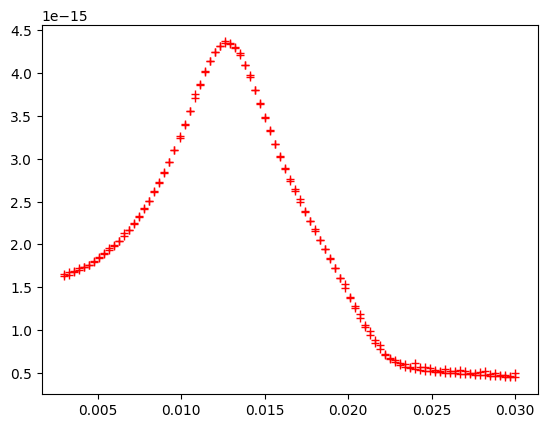

In [ ]:
#m, a,R,v,t0,Phi,x,b,2.5
plt.figure() 
plt.plot(f,data,  '+ ', color='red', label='data')
plt.plot(f,abs(model(log10(6*10**6), 0.01,0.3,2/9,0,pi/3,0.1)),  '+ ', color='red', label='data')
#plt.plot(f,model1(6*10**6*Ms, 9/2,pi/3,0,0,0.01,0.1,2.5*10**9*pc),  '+ ', color='red', label='data')


 *****************************************************
 MultiNest v3.10
 Copyright Farhan Feroz & Mike Hobson
 Release Jul 2015

 no. of live points =  400
 dimensionality =    7
 *****************************************************
 Starting MultiNest
 generating live points
 live points generated, starting sampling
Acceptance Rate:                        0.989011
Replacements:                                450
Total Samples:                               455
Nested Sampling ln(Z):            **************
Importance Nested Sampling ln(Z): ************** +/-  0.998900
Acceptance Rate:                        0.952381
Replacements:                                500
Total Samples:                               525
Nested Sampling ln(Z):            **************
Importance Nested Sampling ln(Z): ************** +/-  0.999047
Acceptance Rate:                        0.925926
Replacements:                                550
Total Samples:                               594
Nested Sampling

/tmp/ipykernel_3717/2547556782.py:20: RuntimeWarning: invalid value encountered in double_scalars
  return 0.44*(1 - 4*v)**0.45*A1(v)


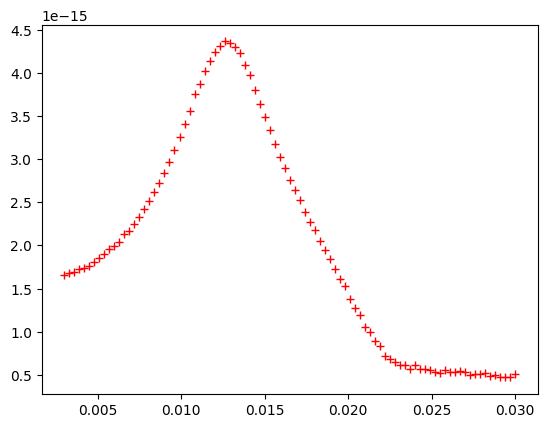

In [ ]:
# run MultiNest
pymultinest.run(loglike, prior, n_params, outputfiles_basename='tditqout3/', resume = False, verbose = True)
json.dump(parameters, open('tditqout3/params.json', 'w'))

'''pymultinest.run(loglike, prior, n_params, outputfiles_basename='out/',
	resume = False, verbose = True)
json.dump(parameters, open('out/params.json', 'w'))'''
plt.figure() 
plt.plot(f, data, '+ ', color='red', label='data')
a = pymultinest.Analyzer(outputfiles_basename='tditqout3/', n_params = n_params)
for (m, a,R,v,Phi,x,b) in a.get_equal_weighted_posterior()[::100,:-1]:
	plt.plot(f, abs(model(m, a,R,v,Phi,x,b)), '-', color='blue', alpha=0.3, label='data')

#plt.savefig('out2/posterior.pdf')
#plt.close()

#a_lnZ = a.get_stats()['global evidence']

  analysing data from tdiout2/.txt
  analysing data from tditqout2/.txt
  analysing data from tditjout2/.txt


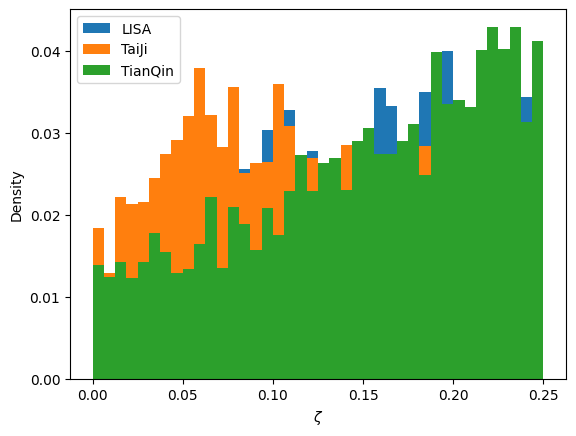

'a = pymultinest.Analyzer(n_params = n_params, outputfiles_basename = prefix)\ns = a.get_stats()\ndata = a.get_data()[:,2:]\nweights = a.get_data()[:,0]\ndata_pa=data[:,-1]\nfig, axes = plt.subplots(1, 1)\naxes.hist(data_pa,bins=40,weights=weights,range=[-8, 8])\nplt.show()'

In [ ]:
#m, a,R,v,Phi,x,b
a = pymultinest.Analyzer(n_params = n_params, outputfiles_basename = 'tdiout2/')
d = pymultinest.Analyzer(n_params = n_params, outputfiles_basename = 'tditqout2/')
tj = pymultinest.Analyzer(n_params = n_params, outputfiles_basename = 'tditjout2/')
s = a.get_stats()
s1 = d.get_stats()
s2 = tj.get_stats()
data = a.get_data()[:,2:]
data1 = d.get_data()[:,2:]
data2 = tj.get_data()[:,2:]
weights = a.get_data()[:,0]
weights1 = d.get_data()[:,0]
weights2 = tj.get_data()[:,0]
#data[:,-1]
fig, axes = plt.subplots(1, 1)
'''axes.hist(data[:,-1],bins=40,weights=weights,range=[0, 0.25], label='LISA,$\zeta=0.15_{-0.08}^{+0.07}$')
axes.hist(data2[:,-1],bins=40,weights=weights2,range=[0, 0.25], label='TaiJi,$\zeta=0.12_{-0.07}^{+0.09}$')
axes.hist(data1[:,-1],bins=40,weights=weights1,range=[0, 0.25], label='TianQin,$\zeta=0.15_{-0.08}^{+0.07}$')'''
axes.hist(data[:,-1],bins=40,weights=weights,range=[0, 0.25], label='LISA')
axes.hist(data2[:,-1],bins=40,weights=weights2,range=[0, 0.25], label='TaiJi')
axes.hist(data1[:,-1],bins=40,weights=weights1,range=[0, 0.25], label='TianQin')
#plt.title('Legend Example 2')
plt.xlabel("$\zeta $")
plt.ylabel('Density')
plt.legend()
plt.savefig('tdi/'+ 'snr1.pdf' )
plt.show()
#plt.figure() 
#plt.plot(data[:,-1],weights,  '+ ', color='red', label='data')
#weights

'''a = pymultinest.Analyzer(n_params = n_params, outputfiles_basename = prefix)
s = a.get_stats()
data = a.get_data()[:,2:]
weights = a.get_data()[:,0]
data_pa=data[:,-1]
fig, axes = plt.subplots(1, 1)
axes.hist(data_pa,bins=40,weights=weights,range=[-8, 8])
plt.show()'''

  analysing data from tdiout3/.txt
  analysing data from tditqout3/.txt
  analysing data from tditjout3/.txt


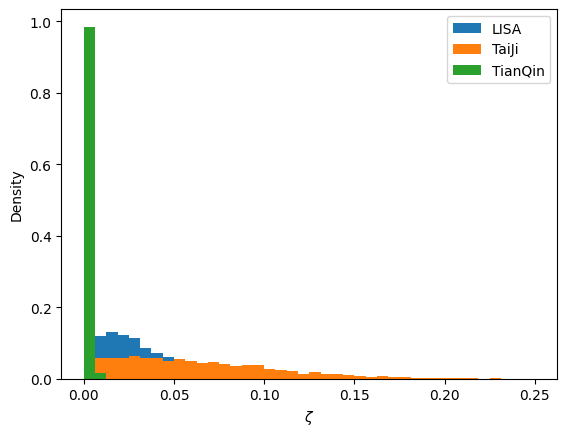

In [ ]:
a = pymultinest.Analyzer(n_params = n_params, outputfiles_basename = 'tdiout3/')
d = pymultinest.Analyzer(n_params = n_params, outputfiles_basename = 'tditqout3/')
tj = pymultinest.Analyzer(n_params = n_params, outputfiles_basename = 'tditjout3/')
s = a.get_stats()
s1 = d.get_stats()
s2 = tj.get_stats()
data = a.get_data()[:,2:]
data1 = d.get_data()[:,2:]
data2 = tj.get_data()[:,2:]
weights = a.get_data()[:,0]
weights1 = d.get_data()[:,0]
weights2 = tj.get_data()[:,0]
#data[:,-1]
fig, axes = plt.subplots(1, 1)
axes.hist(data[:,-1],bins=40,weights=weights,range=[0, 0.25], label='LISA')
axes.hist(data2[:,-1],bins=40,weights=weights2,range=[0, 0.25], label='TaiJi')
axes.hist(data1[:,-1],bins=40,weights=weights1,range=[0, 0.25], label='TianQin')

#plt.title('Legend Example 2')
plt.xlabel("$\zeta $")
plt.ylabel('Density')
plt.legend()
plt.savefig('tdi/'+ 'snr2.pdf' )
plt.show()

In [ ]:
###太极
import json
import sys
import numpy
from numpy import log, exp, pi,sqrt,cos,sin,abs
import scipy.stats, scipy
import pymultinest
import matplotlib.pyplot as plt
#datafile = sys.argv[1]
data = numpy.loadtxt('htdihltotaltj.txt')
#print(data)
Ms = 1.99*10**30
pc = 3.26*9.46*10**15
c = 3*10**8
cG = 6.67*10**-11
def A1(v):
    return 0.864*v

def  A3(v):
    return 0.44*(1 - 4*v)**0.45*A1(v)
#print(A3(0.1))

def  w1(m,b,a):
  return ((0.3736*(1 - 0.03135*b**2 - 0.09674*b**3 + 0.2375*b**4) + 
   2*a*(0.0629 - 0.0156*b**2 - 0.00758*b**3 - 0.0644*b**4 + 0.268*b**5 - 
      0.603*b**6))*c**3)/(cG*((10**m)*Ms))
#print(w1(1.99*10**36,0.1,0.01))  
def  tau1(m,b,a):
  return 1/((((0.0888)*(1 + 0.04371*b**2 + 0.1794*b**3 - 0.2947*b**4) + 
      2*a*(0.00099 - 0.0011*b**2 + 0.01864*b**3 - 0.17271*b**4 + 
         0.56422*b**5 - 0.8119*b**6))*c**3)/(cG*((10**m)*Ms)))
#print(tau1(1.99*10**36,0.1,0.01)) 
def  w3(m,b,a):
     return ((0.5994*(1 - 0.09911*b**2 - 0.04907*b**3 + 0.09286*b**4) + 
   3*a*(0.0674 - 0.0291*b**2 + 0.0251*b**3 - 0.3209*b**4 + 1.1703*b**5 - 
      1.3341*b**6))*c**3)/(cG*((10**m)*Ms))
#print(w3(1.99*10**36,0.1,0.01))
def  tau3(m,b,a):
  return 1/((((0.0927)*(1 + 0.07710*b**2 + 0.1399*b**3 - 0.3450*b**4) + 
     3*a*(0.00065 + 0.00023*b**2 + 0.0233*b**3 - 0.2832*b**4 + 
        1.323*b**5 - 2.442*b**6))*c**3)/(cG*((10**m)*Ms)))
#print(tau3(1.99*10**36,0.1,0.01))
Psi=pi/3
Phi0=0
Theta=0
t0=0
'''fa=[0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1, 0.11, \
0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2, 0.21, 0.22, \
0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.3, 0.31, 0.32, 0.33, \
0.34, 0.35, 0.36, 0.37, 0.38, 0.39, 0.4, 0.41, 0.42, 0.43, 0.44, \
0.45, 0.46, 0.47, 0.48, 0.49, 0.5, 0.51, 0.52, 0.53, 0.54, 0.55, \
0.56, 0.57, 0.58, 0.59, 0.6, 0.61, 0.62, 0.63, 0.64, 0.65, 0.66, \
0.67, 0.68, 0.69, 0.7, 0.71, 0.72, 0.73, 0.74, 0.75, 0.76, 0.77, \
0.78, 0.79, 0.8, 0.81, 0.82, 0.83, 0.84, 0.85, 0.86, 0.87, 0.88, \
0.89, 0.9, 0.91, 0.92, 0.93, 0.94, 0.95, 0.96, 0.97, 0.98, 0.99, 1]'''
fa=numpy.loadtxt('f.txt')
f=numpy.array(fa)
#print(f)

'''def model(M, v, x, t0,Phi,a,b,r):
  h=cG*M*sqrt(5/pi)*A1(v)*cos(x)*cos(Theta)*cos(2*Psi)*sin(2*Phi0)\
   *(((-cos(f*t0 + 2*Phi)*1j + sin(f*t0 + 2*Phi))*1j*tau1(M,b,a))/(2*sqrt(2*pi)*(1j+f*tau1(M,b,a)-tau1(M,b,a)*w1(M,b,a)))\
   -((cos(f*t0 - 2*Phi) + sin(f*t0 - 2*Phi)*1j)*tau1(M,b,a))/(2*sqrt(2*pi)*(1j + f*tau1(M,b,a) + tau1(M,b,a)*w1(M,b,a))))/(2*c**2*r)\
   +cG*M*sqrt(5/pi)*A1(v)*cos(x)*cos(2*Phi0)*sin(2*Psi)\
   *(((-cos(f*t0 + 2*Phi)*1j + sin(f*t0 + 2*Phi))*1j*tau1(M,b,a))/(2*sqrt(2*pi)*(1j+f*tau1(M,b,a)-tau1(M,b,a)*w1(M,b,a)))\
   -((cos(f*t0 - 2*Phi) + sin(f*t0 - 2*Phi)*1j)*tau1(M,b,a))/(2*sqrt(2*pi)*(1j + f*tau1(M,b,a) + tau1(M,b,a)*w1(M,b,a))))/(4*c**2*r)\
   +cG*M*sqrt(5/pi)*A1(v)*cos(x)*cos(Theta)**2*cos(2*Phi0)*sin(2*Psi)\
   *(((-cos(f*t0 + 2*Phi)*1j + sin(f*t0 + 2*Phi))*1j*tau1(M,b,a))/(2*sqrt(2*pi)*(1j+f*tau1(M,b,a)-tau1(M,b,a)*w1(M,b,a)))\
   -((cos(f*t0 - 2*Phi) + sin(f*t0 - 2*Phi)*1j)*tau1(M,b,a))/(2*sqrt(2*pi)*(1j + f*tau1(M,b,a) + tau1(M,b,a)*w1(M,b,a))))/(4*c**2*r)\
   +cG*M*sqrt(5/pi)*A1(v)*cos(2*Phi0)*cos(2*Psi)\
   *(((cos(f*t0 + 2*Phi) + sin(f*t0 + 2*Phi)*1j)*1j*tau1(M,b,a))/(2*sqrt(2*pi)*(1j+f*tau1(M,b,a)-tau1(M,b,a)*w1(M,b,a)))\
   +((cos(f*t0 - 2*Phi) + sin(f*t0 - 2*Phi)*1j)*1j*tau1(M,b,a))/(2*sqrt(2*pi)*(1j + f*tau1(M,b,a) + tau1(M,b,a)*w1(M,b,a))))/(8*c**2*r)\
   +cG*M*sqrt(5/pi)*A1(v)*cos(x)**2*cos(2*Phi0)*cos(2*Psi)\
   *(((cos(f*t0 + 2*Phi) + sin(f*t0 + 2*Phi)*1j)*1j*tau1(M,b,a))/(2*sqrt(2*pi)*(1j+f*tau1(M,b,a)-tau1(M,b,a)*w1(M,b,a)))\
   +((cos(f*t0 - 2*Phi) + sin(f*t0 - 2*Phi)*1j)*1j*tau1(M,b,a))/(2*sqrt(2*pi)*(1j + f*tau1(M,b,a) + tau1(M,b,a)*w1(M,b,a))))/(8*c**2*r)\
   +cG*M*sqrt(5/pi)*A1(v)*cos(Theta)**2*cos(2*Phi0)*cos(2*Psi)\
   *(((cos(f*t0 + 2*Phi) + sin(f*t0 + 2*Phi)*1j)*1j*tau1(M,b,a))/(2*sqrt(2*pi)*(1j+f*tau1(M,b,a)-tau1(M,b,a)*w1(M,b,a)))\
   +((cos(f*t0 - 2*Phi) + sin(f*t0 - 2*Phi)*1j)*1j*tau1(M,b,a))/(2*sqrt(2*pi)*(1j + f*tau1(M,b,a) + tau1(M,b,a)*w1(M,b,a))))/(8*c**2*r)\
   +cG*M*sqrt(5/pi)*A1(v)*cos(x)**2*cos(Theta)**2*cos(2*Phi0)*cos(2*Psi)\
   *(((cos(f*t0 + 2*Phi) + sin(f*t0 + 2*Phi)*1j)*1j*tau1(M,b,a))/(2*sqrt(2*pi)*(1j+f*tau1(M,b,a)-tau1(M,b,a)*w1(M,b,a)))\
   +((cos(f*t0 - 2*Phi) + sin(f*t0 - 2*Phi)*1j)*1j*tau1(M,b,a))/(2*sqrt(2*pi)*(1j + f*tau1(M,b,a) + tau1(M,b,a)*w1(M,b,a))))/(8*c**2*r)\
   -cG*M*sqrt(5/pi)*A1(v)*cos(Theta)*cos(Phi0)*cos(Psi)*sin(Phi0)*sin(Psi)\
   *(((cos(f*t0 + 2*Phi) + sin(f*t0 + 2*Phi)*1j)*1j*tau1(M,b,a))/(2*sqrt(2*pi)*(1j+f*tau1(M,b,a)-tau1(M,b,a)*w1(M,b,a)))\
   +((cos(f*t0 - 2*Phi) + sin(f*t0 - 2*Phi)*1j)*1j*tau1(M,b,a))/(2*sqrt(2*pi)*(1j + f*tau1(M,b,a) + tau1(M,b,a)*w1(M,b,a))))/(c**2*r)\
   -cG*M*sqrt(5/pi)*A1(v)*cos(x)**2*cos(Theta)*cos(Phi0)*cos(Psi)*sin(Phi0)*sin(Psi)\
   *(((cos(f*t0 + 2*Phi) + sin(f*t0 + 2*Phi)*1j)*1j*tau1(M,b,a))/(2*sqrt(2*pi)*(1j+f*tau1(M,b,a)-tau1(M,b,a)*w1(M,b,a)))\
   +((cos(f*t0 - 2*Phi) + sin(f*t0 - 2*Phi)*1j)*1j*tau1(M,b,a))/(2*sqrt(2*pi)*(1j + f*tau1(M,b,a) + tau1(M,b,a)*w1(M,b,a))))/(c**2*r)\
   -cG*M*sqrt(21/(2*pi))*A3(v)*cos(x)*cos(Theta)*cos(2*Psi)*sin(x)*sin(2*Phi0)\
   *(((-cos(f*t0 + 3*Phi)*1j + sin(f*t0 + 3*Phi))*1j*tau3(M,b,a))/(2*sqrt(2*pi)*(1j+f*tau3(M,b,a)-tau3(M,b,a)*w3(M,b,a)))\
   -((cos(f*t0 - 3*Phi) + sin(f*t0 - 3*Phi)*1j)*tau3(M,b,a))/(2*sqrt(2*pi)*(1j + f*tau3(M,b,a) + tau3(M,b,a)*w3(M,b,a))))/(2*c**2*r)\
   -cG*M*sqrt(21/(2*pi))*A3(v)*cos(x)*cos(2*Phi0)*sin(x)*sin(2*Psi)\
   *(((-cos(f*t0 + 3*Phi)*1j + sin(f*t0 + 3*Phi))*1j*tau3(M,b,a))/(2*sqrt(2*pi)*(1j+f*tau3(M,b,a)-tau3(M,b,a)*w3(M,b,a)))\
   -((cos(f*t0 - 3*Phi) + sin(f*t0 - 3*Phi)*1j)*tau3(M,b,a))/(2*sqrt(2*pi)*(1j + f*tau3(M,b,a) + tau3(M,b,a)*w3(M,b,a))))/(4*c**2*r)\
   -cG*M*sqrt(21/(2*pi))*A3(v)*cos(x)*cos(Theta)**2*cos(2*Phi0)*sin(x)*sin(2*Psi)\
   *(((-cos(f*t0 + 3*Phi)*1j + sin(f*t0 + 3*Phi))*1j*tau3(M,b,a))/(2*sqrt(2*pi)*(1j+f*tau3(M,b,a)-tau3(M,b,a)*w3(M,b,a)))\
   -((cos(f*t0 - 3*Phi) + sin(f*t0 - 3*Phi)*1j)*tau3(M,b,a))/(2*sqrt(2*pi)*(1j + f*tau3(M,b,a) + tau3(M,b,a)*w3(M,b,a))))/(4*c**2*r)\
   -cG*M*sqrt(21/(2*pi))*A3(v)*cos(2*Phi0)*cos(2*Psi)*sin(x)\
   *(((cos(f*t0 + 3*Phi) + sin(f*t0 + 3*Phi)*1j)*1j*tau3(M,b,a))/(2*sqrt(2*pi)*(1j+f*tau3(M,b,a)-tau3(M,b,a)*w3(M,b,a)))\
   +((cos(f*t0 - 3*Phi) + sin(f*t0 - 3*Phi)*1j)*1j*tau3(M,b,a))/(2*sqrt(2*pi)*(1j + f*tau3(M,b,a) + tau3(M,b,a)*w3(M,b,a))))/(8*c**2*r)\
   -cG*M*sqrt(21/(2*pi))*A3(v)*cos(x)**2*cos(2*Phi0)*cos(2*Psi)*sin(x)\
   *(((cos(f*t0 + 3*Phi) + sin(f*t0 + 3*Phi)*1j)*1j*tau3(M,b,a))/(2*sqrt(2*pi)*(1j+f*tau3(M,b,a)-tau3(M,b,a)*w3(M,b,a)))\
   +((cos(f*t0 - 3*Phi) + sin(f*t0 - 3*Phi)*1j)*1j*tau3(M,b,a))/(2*sqrt(2*pi)*(1j + f*tau3(M,b,a) + tau3(M,b,a)*w3(M,b,a))))/(8*c**2*r)\
   -cG*M*sqrt(21/(2*pi))*A3(v)*cos(Theta)**2*cos(2*Phi0)*cos(2*Psi)*sin(x)\
   *(((cos(f*t0 + 3*Phi) + sin(f*t0 + 3*Phi)*1j)*1j*tau3(M,b,a))/(2*sqrt(2*pi)*(1j+f*tau3(M,b,a)-tau3(M,b,a)*w3(M,b,a)))\
   +((cos(f*t0 - 3*Phi) + sin(f*t0 - 3*Phi)*1j)*1j*tau3(M,b,a))/(2*sqrt(2*pi)*(1j + f*tau3(M,b,a) + tau3(M,b,a)*w3(M,b,a))))/(8*c**2*r)\
   -cG*M*sqrt(21/(2*pi))*A3(v)*cos(x)**2*cos(Theta)**2*cos(2*Phi0)*cos(2*Psi)*sin(x)\
   *(((cos(f*t0 + 3*Phi) + sin(f*t0 + 3*Phi)*1j)*1j*tau3(M,b,a))/(2*sqrt(2*pi)*(1j+f*tau3(M,b,a)-tau3(M,b,a)*w3(M,b,a)))\
   +((cos(f*t0 - 3*Phi) + sin(f*t0 - 3*Phi)*1j)*1j*tau3(M,b,a))/(2*sqrt(2*pi)*(1j + f*tau3(M,b,a) + tau3(M,b,a)*w3(M,b,a))))/(8*c**2*r)\
   +cG*M*sqrt(21/(2*pi))*A3(v)*cos(Theta)*cos(Phi0)*cos(Psi)*sin(x)*sin(Phi0)*sin(Psi)\
   *(((cos(f*t0 + 3*Phi) + sin(f*t0 + 3*Phi)*1j)*1j*tau3(M,b,a))/(2*sqrt(2*pi)*(1j+f*tau3(M,b,a)-tau3(M,b,a)*w3(M,b,a)))\
   +((cos(f*t0 - 3*Phi) + sin(f*t0 - 3*Phi)*1j)*1j*tau3(M,b,a))/(2*sqrt(2*pi)*(1j + f*tau3(M,b,a) + tau3(M,b,a)*w3(M,b,a))))/(c**2*r)\
   +cG*M*sqrt(21/(2*pi))*A3(v)*cos(x)**2*cos(Theta)*cos(Phi0)*cos(Psi)*sin(x)*sin(Phi0)*sin(Psi)\
   *(((cos(f*t0 + 3*Phi) + sin(f*t0 + 3*Phi)*1j)*1j*tau3(M,b,a))/(2*sqrt(2*pi)*(1j+f*tau3(M,b,a)-tau3(M,b,a)*w3(M,b,a)))\
   +((cos(f*t0 - 3*Phi) + sin(f*t0 - 3*Phi)*1j)*1j*tau3(M,b,a))/(2*sqrt(2*pi)*(1j + f*tau3(M,b,a) + tau3(M,b,a)*w3(M,b,a))))/(c**2*r)
  return h'''
# model(m, a,R,v,t0,Phi,x,b):
def model(m, a,R,v,Phi,x,b):
  h=cG*(10**m)*Ms*sqrt(5/pi)*A1(v)*cos(x)*cos(Theta)*cos(2*Psi)*sin(2*Phi0)\
   *(((-cos(f*t0 + 2*Phi)*1j + sin(f*t0 + 2*Phi))*1j*tau1(m,b,a))/(2*sqrt(2*pi)*(1j+f*tau1(m,b,a)-tau1(m,b,a)*w1(m,b,a)))\
   -((cos(f*t0 - 2*Phi) + sin(f*t0 - 2*Phi)*1j)*tau1(m,b,a))/(2*sqrt(2*pi)*(1j + f*tau1(m,b,a) + tau1(m,b,a)*w1(m,b,a))))/(2*c**2*R*10**9*pc)\
   +cG*(10**m)*Ms*sqrt(5/pi)*A1(v)*cos(x)*cos(2*Phi0)*sin(2*Psi)\
   *(((-cos(f*t0 + 2*Phi)*1j + sin(f*t0 + 2*Phi))*1j*tau1(m,b,a))/(2*sqrt(2*pi)*(1j+f*tau1(m,b,a)-tau1(m,b,a)*w1(m,b,a)))\
   -((cos(f*t0 - 2*Phi) + sin(f*t0 - 2*Phi)*1j)*tau1(m,b,a))/(2*sqrt(2*pi)*(1j + f*tau1(m,b,a) + tau1(m,b,a)*w1(m,b,a))))/(4*c**2*R*10**9*pc)\
   +cG*(10**m)*Ms*sqrt(5/pi)*A1(v)*cos(x)*cos(Theta)**2*cos(2*Phi0)*sin(2*Psi)\
   *(((-cos(f*t0 + 2*Phi)*1j + sin(f*t0 + 2*Phi))*1j*tau1(m,b,a))/(2*sqrt(2*pi)*(1j+f*tau1(m,b,a)-tau1(m,b,a)*w1(m,b,a)))\
   -((cos(f*t0 - 2*Phi) + sin(f*t0 - 2*Phi)*1j)*tau1(m,b,a))/(2*sqrt(2*pi)*(1j + f*tau1(m,b,a) + tau1(m,b,a)*w1(m,b,a))))/(4*c**2*R*10**9*pc)\
   +cG*(10**m)*Ms*sqrt(5/pi)*A1(v)*cos(2*Phi0)*cos(2*Psi)\
   *(((cos(f*t0 + 2*Phi) + sin(f*t0 + 2*Phi)*1j)*1j*tau1(m,b,a))/(2*sqrt(2*pi)*(1j+f*tau1(m,b,a)-tau1(m,b,a)*w1(m,b,a)))\
   +((cos(f*t0 - 2*Phi) + sin(f*t0 - 2*Phi)*1j)*1j*tau1(m,b,a))/(2*sqrt(2*pi)*(1j + f*tau1(m,b,a) + tau1(m,b,a)*w1(m,b,a))))/(8*c**2*R*10**9*pc)\
   +cG*(10**m)*Ms*sqrt(5/pi)*A1(v)*cos(x)**2*cos(2*Phi0)*cos(2*Psi)\
   *(((cos(f*t0 + 2*Phi) + sin(f*t0 + 2*Phi)*1j)*1j*tau1(m,b,a))/(2*sqrt(2*pi)*(1j+f*tau1(m,b,a)-tau1(m,b,a)*w1(m,b,a)))\
   +((cos(f*t0 - 2*Phi) + sin(f*t0 - 2*Phi)*1j)*1j*tau1(m,b,a))/(2*sqrt(2*pi)*(1j + f*tau1(m,b,a) + tau1(m,b,a)*w1(m,b,a))))/(8*c**2*R*10**9*pc)\
   +cG*(10**m)*Ms*sqrt(5/pi)*A1(v)*cos(Theta)**2*cos(2*Phi0)*cos(2*Psi)\
   *(((cos(f*t0 + 2*Phi) + sin(f*t0 + 2*Phi)*1j)*1j*tau1(m,b,a))/(2*sqrt(2*pi)*(1j+f*tau1(m,b,a)-tau1(m,b,a)*w1(m,b,a)))\
   +((cos(f*t0 - 2*Phi) + sin(f*t0 - 2*Phi)*1j)*1j*tau1(m,b,a))/(2*sqrt(2*pi)*(1j + f*tau1(m,b,a) + tau1(m,b,a)*w1(m,b,a))))/(8*c**2*R*10**9*pc)\
   +cG*(10**m)*Ms*sqrt(5/pi)*A1(v)*cos(x)**2*cos(Theta)**2*cos(2*Phi0)*cos(2*Psi)\
   *(((cos(f*t0 + 2*Phi) + sin(f*t0 + 2*Phi)*1j)*1j*tau1(m,b,a))/(2*sqrt(2*pi)*(1j+f*tau1(m,b,a)-tau1(m,b,a)*w1(m,b,a)))\
   +((cos(f*t0 - 2*Phi) + sin(f*t0 - 2*Phi)*1j)*1j*tau1(m,b,a))/(2*sqrt(2*pi)*(1j + f*tau1(m,b,a) + tau1(m,b,a)*w1(m,b,a))))/(8*c**2*R*10**9*pc)\
   -cG*(10**m)*Ms*sqrt(5/pi)*A1(v)*cos(Theta)*cos(Phi0)*cos(Psi)*sin(Phi0)*sin(Psi)\
   *(((cos(f*t0 + 2*Phi) + sin(f*t0 + 2*Phi)*1j)*1j*tau1(m,b,a))/(2*sqrt(2*pi)*(1j+f*tau1(m,b,a)-tau1(m,b,a)*w1(m,b,a)))\
   +((cos(f*t0 - 2*Phi) + sin(f*t0 - 2*Phi)*1j)*1j*tau1(m,b,a))/(2*sqrt(2*pi)*(1j + f*tau1(m,b,a) + tau1(m,b,a)*w1(m,b,a))))/(c**2*R*10**9*pc)\
   -cG*(10**m)*Ms*sqrt(5/pi)*A1(v)*cos(x)**2*cos(Theta)*cos(Phi0)*cos(Psi)*sin(Phi0)*sin(Psi)\
   *(((cos(f*t0 + 2*Phi) + sin(f*t0 + 2*Phi)*1j)*1j*tau1(m,b,a))/(2*sqrt(2*pi)*(1j+f*tau1(m,b,a)-tau1(m,b,a)*w1(m,b,a)))\
   +((cos(f*t0 - 2*Phi) + sin(f*t0 - 2*Phi)*1j)*1j*tau1(m,b,a))/(2*sqrt(2*pi)*(1j + f*tau1(m,b,a) + tau1(m,b,a)*w1(m,b,a))))/(c**2*R*10**9*pc)\
   -cG*(10**m)*Ms*sqrt(21/(2*pi))*A3(v)*cos(x)*cos(Theta)*cos(2*Psi)*sin(x)*sin(2*Phi0)\
   *(((-cos(f*t0 + 3*Phi)*1j + sin(f*t0 + 3*Phi))*1j*tau3(m,b,a))/(2*sqrt(2*pi)*(1j+f*tau3(m,b,a)-tau3(m,b,a)*w3(m,b,a)))\
   -((cos(f*t0 - 3*Phi) + sin(f*t0 - 3*Phi)*1j)*tau3(m,b,a))/(2*sqrt(2*pi)*(1j + f*tau3(m,b,a) + tau3(m,b,a)*w3(m,b,a))))/(2*c**2*R*10**9*pc)\
   -cG*(10**m)*Ms*sqrt(21/(2*pi))*A3(v)*cos(x)*cos(2*Phi0)*sin(x)*sin(2*Psi)\
   *(((-cos(f*t0 + 3*Phi)*1j + sin(f*t0 + 3*Phi))*1j*tau3(m,b,a))/(2*sqrt(2*pi)*(1j+f*tau3(m,b,a)-tau3(m,b,a)*w3(m,b,a)))\
   -((cos(f*t0 - 3*Phi) + sin(f*t0 - 3*Phi)*1j)*tau3(m,b,a))/(2*sqrt(2*pi)*(1j + f*tau3(m,b,a) + tau3(m,b,a)*w3(m,b,a))))/(4*c**2*R*10**9*pc)\
   -cG*(10**m)*Ms*sqrt(21/(2*pi))*A3(v)*cos(x)*cos(Theta)**2*cos(2*Phi0)*sin(x)*sin(2*Psi)\
   *(((-cos(f*t0 + 3*Phi)*1j + sin(f*t0 + 3*Phi))*1j*tau3(m,b,a))/(2*sqrt(2*pi)*(1j+f*tau3(m,b,a)-tau3(m,b,a)*w3(m,b,a)))\
   -((cos(f*t0 - 3*Phi) + sin(f*t0 - 3*Phi)*1j)*tau3(m,b,a))/(2*sqrt(2*pi)*(1j + f*tau3(m,b,a) + tau3(m,b,a)*w3(m,b,a))))/(4*c**2*R*10**9*pc)\
   -cG*(10**m)*Ms*sqrt(21/(2*pi))*A3(v)*cos(2*Phi0)*cos(2*Psi)*sin(x)\
   *(((cos(f*t0 + 3*Phi) + sin(f*t0 + 3*Phi)*1j)*1j*tau3(m,b,a))/(2*sqrt(2*pi)*(1j+f*tau3(m,b,a)-tau3(m,b,a)*w3(m,b,a)))\
   +((cos(f*t0 - 3*Phi) + sin(f*t0 - 3*Phi)*1j)*1j*tau3(m,b,a))/(2*sqrt(2*pi)*(1j + f*tau3(m,b,a) + tau3(m,b,a)*w3(m,b,a))))/(8*c**2*R*10**9*pc)\
   -cG*(10**m)*Ms*sqrt(21/(2*pi))*A3(v)*cos(x)**2*cos(2*Phi0)*cos(2*Psi)*sin(x)\
   *(((cos(f*t0 + 3*Phi) + sin(f*t0 + 3*Phi)*1j)*1j*tau3(m,b,a))/(2*sqrt(2*pi)*(1j+f*tau3(m,b,a)-tau3(m,b,a)*w3(m,b,a)))\
   +((cos(f*t0 - 3*Phi) + sin(f*t0 - 3*Phi)*1j)*1j*tau3(m,b,a))/(2*sqrt(2*pi)*(1j + f*tau3(m,b,a) + tau3(m,b,a)*w3(m,b,a))))/(8*c**2*R*10**9*pc)\
   -cG*(10**m)*Ms*sqrt(21/(2*pi))*A3(v)*cos(Theta)**2*cos(2*Phi0)*cos(2*Psi)*sin(x)\
   *(((cos(f*t0 + 3*Phi) + sin(f*t0 + 3*Phi)*1j)*1j*tau3(m,b,a))/(2*sqrt(2*pi)*(1j+f*tau3(m,b,a)-tau3(m,b,a)*w3(m,b,a)))\
   +((cos(f*t0 - 3*Phi) + sin(f*t0 - 3*Phi)*1j)*1j*tau3(m,b,a))/(2*sqrt(2*pi)*(1j + f*tau3(m,b,a) + tau3(m,b,a)*w3(m,b,a))))/(8*c**2*R*10**9*pc)\
   -cG*(10**m)*Ms*sqrt(21/(2*pi))*A3(v)*cos(x)**2*cos(Theta)**2*cos(2*Phi0)*cos(2*Psi)*sin(x)\
   *(((cos(f*t0 + 3*Phi) + sin(f*t0 + 3*Phi)*1j)*1j*tau3(m,b,a))/(2*sqrt(2*pi)*(1j+f*tau3(m,b,a)-tau3(m,b,a)*w3(m,b,a)))\
   +((cos(f*t0 - 3*Phi) + sin(f*t0 - 3*Phi)*1j)*1j*tau3(m,b,a))/(2*sqrt(2*pi)*(1j + f*tau3(m,b,a) + tau3(m,b,a)*w3(m,b,a))))/(8*c**2*R*10**9*pc)\
   +cG*(10**m)*Ms*sqrt(21/(2*pi))*A3(v)*cos(Theta)*cos(Phi0)*cos(Psi)*sin(x)*sin(Phi0)*sin(Psi)\
   *(((cos(f*t0 + 3*Phi) + sin(f*t0 + 3*Phi)*1j)*1j*tau3(m,b,a))/(2*sqrt(2*pi)*(1j+f*tau3(m,b,a)-tau3(m,b,a)*w3(m,b,a)))\
   +((cos(f*t0 - 3*Phi) + sin(f*t0 - 3*Phi)*1j)*1j*tau3(m,b,a))/(2*sqrt(2*pi)*(1j + f*tau3(m,b,a) + tau3(m,b,a)*w3(m,b,a))))/(c**2*R*10**9*pc)\
   +cG*(10**m)*Ms*sqrt(21/(2*pi))*A3(v)*cos(x)**2*cos(Theta)*cos(Phi0)*cos(Psi)*sin(x)*sin(Phi0)*sin(Psi)\
   *(((cos(f*t0 + 3*Phi) + sin(f*t0 + 3*Phi)*1j)*1j*tau3(m,b,a))/(2*sqrt(2*pi)*(1j+f*tau3(m,b,a)-tau3(m,b,a)*w3(m,b,a)))\
   +((cos(f*t0 - 3*Phi) + sin(f*t0 - 3*Phi)*1j)*1j*tau3(m,b,a))/(2*sqrt(2*pi)*(1j + f*tau3(m,b,a) + tau3(m,b,a)*w3(m,b,a))))/(c**2*R*10**9*pc)
  return h

#print(model(10**6*Ms, 2/9, pi/3, 0,0,0.01,0.1,2.5*10**9*pc))
'''noisea=[6.026930881180586*10**-20, 6.001203405331356*10**-20, \
6.000190141567148*10**-20, 6.000075197347526*10**-20, \
6.000043119730023*10**-20, 6.0000237648569184*10**-20, \
6.000011224097523*10**-20, 6.0000046995093765*10**-20, \
6.000002347092599*10**-20, 6.000001924902162*10**-20, \
6.000001840622609*10**-20, 6.000001485256807*10**-20, \
6.000000943540367*10**-20, 6.000000501063959*10**-20, \
6.000000304179407*10**-20, 6.000000293713936*10**-20, \
6.0000003226536065*10**-20, 6.000000293382278*10**-20, \
6.0000002067841895*10**-20, 6.000000120304959*10**-20, \
6.000000079180121*10**-20, 6.000000082169849*10**-20, \
6.000000096298557*10**-20, 6.000000092827787*10**-20, \
6.000000068987577*10**-20, 6.0000000421220415*10**-20, \
6.000000028975948*10**-20, 6.000000031316307*10**-20, \
6.000000038101199*10**-20, 6.000000038022223*10**-20, \
6.0000000291798976*10**-20, 6.000000018357035*10**-20, \
6.000000012984841*10**-20, 6.000000014404119*10**-20, \
6.000000017958009*10**-20, 6.0000000183363244*10**-20, \
6.000000014378826*10**-20, 6.000000009231406*10**-20, \
6.000000006656314*10**-20, 6.000000007519037*10**-20, \
6.000000009536627*10**-20, 6.000000009897488*10**-20, \
6.000000007882362*10**-20, 6.0000000051356026*10**-20, \
6.000000003755277*10**-20, 6.000000004299033*10**-20, \
6.000000005522537*10**-20, 6.0000000058017246*10**-20, \
6.000000004674614*10**-20, 6.0000000030797965*10**-20, \
6.0000000022762045*10**-20, 6.000000002632623*10**-20, \
6.000000003415282*10**-20, 6.000000003621987*10**-20, \
6.000000002944959*10**-20, 6.000000001957266*10**-20, \
6.000000001458789*10**-20, 6.0000000017009435*10**-20, \
6.0000000022239336*10**-20, 6.000000002376385*10**-20, \
6.000000001946303*10**-20, 6.0000000013026725*10**-20, \
6.000000000977529*10**-20, 6.000000001147313*10**-20, \
6.0000000015096505*10**-20, 6.000000001623103*10**-20, \
6.0000000013373054*10**-20, 6.000000000900256*10**-20, \
6.000000000679353*10**-20, 6.000000000801696*10**-20, \
6.000000001060465*10**-20, 6.000000001146019*10**-20, \
6.000000000948939*10**-20, 6.000000000641911*10**-20, \
6.000000000486683*10**-20, 6.000000000576962*10**-20, \
6.000000000766597*10**-20, 6.0000000008320384*10**-20, \
6.000000000691865*10**-20, 6.0000000004699395*10**-20, \
6.000000000357726*10**-20, 6.000000000425742*10**-20, \
6.000000000567829*10**-20, 6.000000000618592*10**-20, \
6.000000000516242*10**-20, 6.0000000003518905*10**-20, \
6.0000000002687904*10**-20, 6.000000000320975*10**-20, \
6.000000000429506*10**-20, 6.000000000469409*10**-20, \
6.0000000003929745*10**-20, 6.0000000002686896*10**-20, \
6.000000000205854*10**-20, 6.0000000002465414*10**-20, \
6.000000000330853*10**-20, 6.000000000362607*10**-20, \
6.000000000304398*10**-20, 6.000000000208688*10**-20, \
6.0000000001603064*10**-20, 6.000000000192487*10**-20]'''
noisea = numpy.loadtxt('htdihlnoitj.txt')
noise=numpy.array(noisea)
#(m, a,R,v,t0,Phi,x,b)
#m, a,R,v,Phi,x,b
#v = 2/9; Phi0 = 0; Psi = pi/3;Phi= 0;Theta= 0; r = 2.5*10^9 pc;a=0.01;t0= 0;x=pi]/3;b = 0.1;M = 10^6 Ms;
def prior(cube, ndim, nparams):
    cube[0] = cube[0]*12+1 # uniform prior between M = 10^5.698970004336018` Ms; 1 and 10^11
    cube[1] = cube[1]*0.025+0.001  #  a=0.01 0.001 and 0.051 #  v = 2/9; 1/9 and 3/9
    cube[2] = cube[1]*5+1       #  r = 2.5*10^9 pc  2*10^9 pc and 3*10^9 pc
    cube[3] = cube[3]*2/9+1/9     #v = 2/9
    #cube[4] = cube[3]*0.1   #  t0= 0 
    cube[4] = cube[4]*2*pi  #  Phi= 0
    cube[5] = cube[5]*pi # x=pi
    cube[6] = cube[6]*0.25  #b = 0.1
'''def prior(cube, ndim, nparams):
    cube[0] = 10**(cube[0]*7) # uniform prior between M = 10^6 Ms; 1 and 10^7
	  cube[1] = cube[1]*2/9+1/9 #  v = 2/9; 1/9 and 3/9
	  cube[2] = cube[1]*pi
	  cube[3] = cube[3]*0.01
    cube[4] = cube[4]*2*pi    #  Phi= 0 0 and 2pi
    cube[5] = cube[5]*0.05+0.001   #  a=0.01 0.001 and 0.051
    cube[6] = cube[6]*0.1+0.05 # b = 0.1 0.05 and 0.15
    cube[7] = ((cube[7]+2)*10**9*pc)  #uniform prior between r = 2.5*10^9 pc  2*10^9 pc and 3*10^9 pc'''
#m, a,R,v,t0,Phi,x,b
def loglike(cube, ndim, nparams):
  m,a,R,v,Phi,x,b = cube[0], cube[1], cube[2],cube[3],cube[4],cube[5],cube[6]#,cube[7]
  ymodel = abs(model(m,a,R,v,Phi,x,b))
  loglikelihood = (-0.5 * ((ymodel - data) / noise)**2).sum()
  return loglikelihood

# number of dimensions our problem has
#"$Log({M_Z}/{M_ \odot })$", "${\chi _f}$","$Log({D_L}/Gpc)$","$\nu $","${{t_0}}$","$\phi $","$\iota $","$\zeta $"
parameters = ["$Lo{g_{10}}({M_Z}/{M_ \odot })$", "${\chi _f}$","$Lo{g_{10}}({D_L}/Gpc)$","$v$","$\phi $","$\iota $","$\zeta $"]
n_params = len(parameters)


 *****************************************************
 MultiNest v3.10
 Copyright Farhan Feroz & Mike Hobson
 Release Jul 2015

 no. of live points =  400
 dimensionality =    7
 *****************************************************
 Starting MultiNest
 generating live points
 live points generated, starting sampling
Acceptance Rate:                        0.993377
Replacements:                                450
Total Samples:                               453
Nested Sampling ln(Z):            **************
Importance Nested Sampling ln(Z):   -4299.555121 +/-  0.998896
Acceptance Rate:                        0.967118
Replacements:                                500
Total Samples:                               517
Nested Sampling ln(Z):            **************
Importance Nested Sampling ln(Z):   -4299.687271 +/-  0.999032
Acceptance Rate:                        0.949914
Replacements:                                550
Total Samples:                               579
Nested Sampling

/tmp/ipykernel_575/182139847.py:20: RuntimeWarning: invalid value encountered in double_scalars
  return 0.44*(1 - 4*v)**0.45*A1(v)


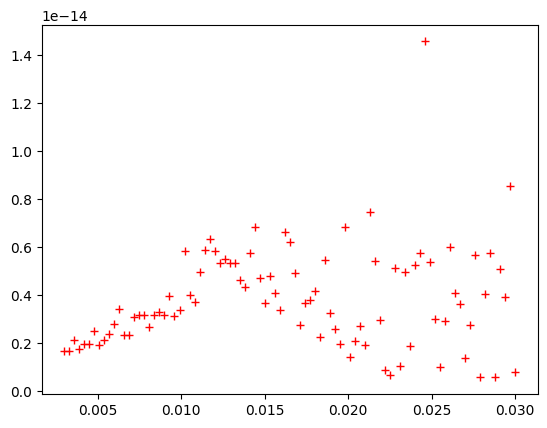

In [ ]:
# run MultiNest
pymultinest.run(loglike, prior, n_params, outputfiles_basename='tditjout3/', resume = False, verbose = True)
json.dump(parameters, open('tditjout3/params.json', 'w'))

'''pymultinest.run(loglike, prior, n_params, outputfiles_basename='out/',
	resume = False, verbose = True)
json.dump(parameters, open('out/params.json', 'w'))'''
plt.figure() 
plt.plot(f, data, '+ ', color='red', label='data')
a = pymultinest.Analyzer(outputfiles_basename='tditjout3/', n_params = n_params)
for (m, a,R,v,Phi,x,b) in a.get_equal_weighted_posterior()[::100,:-1]:
	plt.plot(f, abs(model(m, a,R,v,Phi,x,b)), '-', color='blue', alpha=0.3, label='data')

#plt.savefig('out2/posterior.pdf')
#plt.close()

#a_lnZ = a.get_stats()['global evidence']

In [ ]:
#tianqin
import json
import sys
import numpy
from numpy import log, exp, pi,sqrt,cos,sin,abs
import scipy.stats, scipy
import pymultinest
import matplotlib.pyplot as plt
#datafile = sys.argv[1]
data = numpy.loadtxt('tqabc.txt')
#print(data)
Ms = 1.99*10**30
pc = 3.26*9.46*10**15
c = 3*10**8
cG = 6.67*10**-11
def A1(v):
    return 0.864*v

def  A3(v):
    return 0.44*(1 - 4*v)**0.45*A1(v)
#print(A3(0.1))

def  w1(m,b,a):
  return ((0.3736*(1 - 0.03135*b**2 - 0.09674*b**3 + 0.2375*b**4) + 
   2*a*(0.0629 - 0.0156*b**2 - 0.00758*b**3 - 0.0644*b**4 + 0.268*b**5 - 
      0.603*b**6))*c**3)/(cG*((10**m)*Ms))
#print(w1(1.99*10**36,0.1,0.01))  
def  tau1(m,b,a):
  return 1/((((0.0888)*(1 + 0.04371*b**2 + 0.1794*b**3 - 0.2947*b**4) + 
      2*a*(0.00099 - 0.0011*b**2 + 0.01864*b**3 - 0.17271*b**4 + 
         0.56422*b**5 - 0.8119*b**6))*c**3)/(cG*((10**m)*Ms)))
#print(tau1(1.99*10**36,0.1,0.01)) 
def  w3(m,b,a):
     return ((0.5994*(1 - 0.09911*b**2 - 0.04907*b**3 + 0.09286*b**4) + 
   3*a*(0.0674 - 0.0291*b**2 + 0.0251*b**3 - 0.3209*b**4 + 1.1703*b**5 - 
      1.3341*b**6))*c**3)/(cG*((10**m)*Ms))
#print(w3(1.99*10**36,0.1,0.01))
def  tau3(m,b,a):
  return 1/((((0.0927)*(1 + 0.07710*b**2 + 0.1399*b**3 - 0.3450*b**4) + 
     3*a*(0.00065 + 0.00023*b**2 + 0.0233*b**3 - 0.2832*b**4 + 
        1.323*b**5 - 2.442*b**6))*c**3)/(cG*((10**m)*Ms)))
#print(tau3(1.99*10**36,0.1,0.01))
Psi=pi/3
Phi0=0
Theta=0
t0=0
fa=[0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1, 0.11, \
0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2, 0.21, 0.22, \
0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.3, 0.31, 0.32, 0.33, \
0.34, 0.35, 0.36, 0.37, 0.38, 0.39, 0.4, 0.41, 0.42, 0.43, 0.44, \
0.45, 0.46, 0.47, 0.48, 0.49, 0.5, 0.51, 0.52, 0.53, 0.54, 0.55, \
0.56, 0.57, 0.58, 0.59, 0.6, 0.61, 0.62, 0.63, 0.64, 0.65, 0.66, \
0.67, 0.68, 0.69, 0.7, 0.71, 0.72, 0.73, 0.74, 0.75, 0.76, 0.77, \
0.78, 0.79, 0.8, 0.81, 0.82, 0.83, 0.84, 0.85, 0.86, 0.87, 0.88, \
0.89, 0.9, 0.91, 0.92, 0.93, 0.94, 0.95, 0.96, 0.97, 0.98, 0.99, 1]
f=numpy.array(fa)
def model(m, v, x, Phi,a,b,R):
  h=cG*(10**m)*Ms*sqrt(5/pi)*A1(v)*cos(x)*cos(Theta)*cos(2*Psi)*sin(2*Phi0)\
   *(((-cos(f*t0 + 2*Phi)*1j + sin(f*t0 + 2*Phi))*1j*tau1(m,b,a))/(2*sqrt(2*pi)*(1j+f*tau1(m,b,a)-tau1(m,b,a)*w1(m,b,a)))\
   -((cos(f*t0 - 2*Phi) + sin(f*t0 - 2*Phi)*1j)*tau1(m,b,a))/(2*sqrt(2*pi)*(1j + f*tau1(m,b,a) + tau1(m,b,a)*w1(m,b,a))))/(2*c**2*R*10**9*pc)\
   +cG*(10**m)*Ms*sqrt(5/pi)*A1(v)*cos(x)*cos(2*Phi0)*sin(2*Psi)\
   *(((-cos(f*t0 + 2*Phi)*1j + sin(f*t0 + 2*Phi))*1j*tau1(m,b,a))/(2*sqrt(2*pi)*(1j+f*tau1(m,b,a)-tau1(m,b,a)*w1(m,b,a)))\
   -((cos(f*t0 - 2*Phi) + sin(f*t0 - 2*Phi)*1j)*tau1(m,b,a))/(2*sqrt(2*pi)*(1j + f*tau1(m,b,a) + tau1(m,b,a)*w1(m,b,a))))/(4*c**2*R*10**9*pc)\
   +cG*(10**m)*Ms*sqrt(5/pi)*A1(v)*cos(x)*cos(Theta)**2*cos(2*Phi0)*sin(2*Psi)\
   *(((-cos(f*t0 + 2*Phi)*1j + sin(f*t0 + 2*Phi))*1j*tau1(m,b,a))/(2*sqrt(2*pi)*(1j+f*tau1(m,b,a)-tau1(m,b,a)*w1(m,b,a)))\
   -((cos(f*t0 - 2*Phi) + sin(f*t0 - 2*Phi)*1j)*tau1(m,b,a))/(2*sqrt(2*pi)*(1j + f*tau1(m,b,a) + tau1(m,b,a)*w1(m,b,a))))/(4*c**2*R*10**9*pc)\
   +cG*(10**m)*Ms*sqrt(5/pi)*A1(v)*cos(2*Phi0)*cos(2*Psi)\
   *(((cos(f*t0 + 2*Phi) + sin(f*t0 + 2*Phi)*1j)*1j*tau1(m,b,a))/(2*sqrt(2*pi)*(1j+f*tau1(m,b,a)-tau1(m,b,a)*w1(m,b,a)))\
   +((cos(f*t0 - 2*Phi) + sin(f*t0 - 2*Phi)*1j)*1j*tau1(m,b,a))/(2*sqrt(2*pi)*(1j + f*tau1(m,b,a) + tau1(m,b,a)*w1(m,b,a))))/(8*c**2*R*10**9*pc)\
   +cG*(10**m)*Ms*sqrt(5/pi)*A1(v)*cos(x)**2*cos(2*Phi0)*cos(2*Psi)\
   *(((cos(f*t0 + 2*Phi) + sin(f*t0 + 2*Phi)*1j)*1j*tau1(m,b,a))/(2*sqrt(2*pi)*(1j+f*tau1(m,b,a)-tau1(m,b,a)*w1(m,b,a)))\
   +((cos(f*t0 - 2*Phi) + sin(f*t0 - 2*Phi)*1j)*1j*tau1(m,b,a))/(2*sqrt(2*pi)*(1j + f*tau1(m,b,a) + tau1(m,b,a)*w1(m,b,a))))/(8*c**2*R*10**9*pc)\
   +cG*(10**m)*Ms*sqrt(5/pi)*A1(v)*cos(Theta)**2*cos(2*Phi0)*cos(2*Psi)\
   *(((cos(f*t0 + 2*Phi) + sin(f*t0 + 2*Phi)*1j)*1j*tau1(m,b,a))/(2*sqrt(2*pi)*(1j+f*tau1(m,b,a)-tau1(m,b,a)*w1(m,b,a)))\
   +((cos(f*t0 - 2*Phi) + sin(f*t0 - 2*Phi)*1j)*1j*tau1(m,b,a))/(2*sqrt(2*pi)*(1j + f*tau1(m,b,a) + tau1(m,b,a)*w1(m,b,a))))/(8*c**2*R*10**9*pc)\
   +cG*(10**m)*Ms*sqrt(5/pi)*A1(v)*cos(x)**2*cos(Theta)**2*cos(2*Phi0)*cos(2*Psi)\
   *(((cos(f*t0 + 2*Phi) + sin(f*t0 + 2*Phi)*1j)*1j*tau1(m,b,a))/(2*sqrt(2*pi)*(1j+f*tau1(m,b,a)-tau1(m,b,a)*w1(m,b,a)))\
   +((cos(f*t0 - 2*Phi) + sin(f*t0 - 2*Phi)*1j)*1j*tau1(m,b,a))/(2*sqrt(2*pi)*(1j + f*tau1(m,b,a) + tau1(m,b,a)*w1(m,b,a))))/(8*c**2*R*10**9*pc)\
   -cG*(10**m)*Ms*sqrt(5/pi)*A1(v)*cos(Theta)*cos(Phi0)*cos(Psi)*sin(Phi0)*sin(Psi)\
   *(((cos(f*t0 + 2*Phi) + sin(f*t0 + 2*Phi)*1j)*1j*tau1(m,b,a))/(2*sqrt(2*pi)*(1j+f*tau1(m,b,a)-tau1(m,b,a)*w1(m,b,a)))\
   +((cos(f*t0 - 2*Phi) + sin(f*t0 - 2*Phi)*1j)*1j*tau1(m,b,a))/(2*sqrt(2*pi)*(1j + f*tau1(m,b,a) + tau1(m,b,a)*w1(m,b,a))))/(c**2*R*10**9*pc)\
   -cG*(10**m)*Ms*sqrt(5/pi)*A1(v)*cos(x)**2*cos(Theta)*cos(Phi0)*cos(Psi)*sin(Phi0)*sin(Psi)\
   *(((cos(f*t0 + 2*Phi) + sin(f*t0 + 2*Phi)*1j)*1j*tau1(m,b,a))/(2*sqrt(2*pi)*(1j+f*tau1(m,b,a)-tau1(m,b,a)*w1(m,b,a)))\
   +((cos(f*t0 - 2*Phi) + sin(f*t0 - 2*Phi)*1j)*1j*tau1(m,b,a))/(2*sqrt(2*pi)*(1j + f*tau1(m,b,a) + tau1(m,b,a)*w1(m,b,a))))/(c**2*R*10**9*pc)\
   -cG*(10**m)*Ms*sqrt(21/(2*pi))*A3(v)*cos(x)*cos(Theta)*cos(2*Psi)*sin(x)*sin(2*Phi0)\
   *(((-cos(f*t0 + 3*Phi)*1j + sin(f*t0 + 3*Phi))*1j*tau3(m,b,a))/(2*sqrt(2*pi)*(1j+f*tau3(m,b,a)-tau3(m,b,a)*w3(m,b,a)))\
   -((cos(f*t0 - 3*Phi) + sin(f*t0 - 3*Phi)*1j)*tau3(m,b,a))/(2*sqrt(2*pi)*(1j + f*tau3(m,b,a) + tau3(m,b,a)*w3(m,b,a))))/(2*c**2*R*10**9*pc)\
   -cG*(10**m)*Ms*sqrt(21/(2*pi))*A3(v)*cos(x)*cos(2*Phi0)*sin(x)*sin(2*Psi)\
   *(((-cos(f*t0 + 3*Phi)*1j + sin(f*t0 + 3*Phi))*1j*tau3(m,b,a))/(2*sqrt(2*pi)*(1j+f*tau3(m,b,a)-tau3(m,b,a)*w3(m,b,a)))\
   -((cos(f*t0 - 3*Phi) + sin(f*t0 - 3*Phi)*1j)*tau3(m,b,a))/(2*sqrt(2*pi)*(1j + f*tau3(m,b,a) + tau3(m,b,a)*w3(m,b,a))))/(4*c**2*R*10**9*pc)\
   -cG*(10**m)*Ms*sqrt(21/(2*pi))*A3(v)*cos(x)*cos(Theta)**2*cos(2*Phi0)*sin(x)*sin(2*Psi)\
   *(((-cos(f*t0 + 3*Phi)*1j + sin(f*t0 + 3*Phi))*1j*tau3(m,b,a))/(2*sqrt(2*pi)*(1j+f*tau3(m,b,a)-tau3(m,b,a)*w3(m,b,a)))\
   -((cos(f*t0 - 3*Phi) + sin(f*t0 - 3*Phi)*1j)*tau3(m,b,a))/(2*sqrt(2*pi)*(1j + f*tau3(m,b,a) + tau3(m,b,a)*w3(m,b,a))))/(4*c**2*R*10**9*pc)\
   -cG*(10**m)*Ms*sqrt(21/(2*pi))*A3(v)*cos(2*Phi0)*cos(2*Psi)*sin(x)\
   *(((cos(f*t0 + 3*Phi) + sin(f*t0 + 3*Phi)*1j)*1j*tau3(m,b,a))/(2*sqrt(2*pi)*(1j+f*tau3(m,b,a)-tau3(m,b,a)*w3(m,b,a)))\
   +((cos(f*t0 - 3*Phi) + sin(f*t0 - 3*Phi)*1j)*1j*tau3(m,b,a))/(2*sqrt(2*pi)*(1j + f*tau3(m,b,a) + tau3(m,b,a)*w3(m,b,a))))/(8*c**2*R*10**9*pc)\
   -cG*(10**m)*Ms*sqrt(21/(2*pi))*A3(v)*cos(x)**2*cos(2*Phi0)*cos(2*Psi)*sin(x)\
   *(((cos(f*t0 + 3*Phi) + sin(f*t0 + 3*Phi)*1j)*1j*tau3(m,b,a))/(2*sqrt(2*pi)*(1j+f*tau3(m,b,a)-tau3(m,b,a)*w3(m,b,a)))\
   +((cos(f*t0 - 3*Phi) + sin(f*t0 - 3*Phi)*1j)*1j*tau3(m,b,a))/(2*sqrt(2*pi)*(1j + f*tau3(m,b,a) + tau3(m,b,a)*w3(m,b,a))))/(8*c**2*R*10**9*pc)\
   -cG*(10**m)*Ms*sqrt(21/(2*pi))*A3(v)*cos(Theta)**2*cos(2*Phi0)*cos(2*Psi)*sin(x)\
   *(((cos(f*t0 + 3*Phi) + sin(f*t0 + 3*Phi)*1j)*1j*tau3(m,b,a))/(2*sqrt(2*pi)*(1j+f*tau3(m,b,a)-tau3(m,b,a)*w3(m,b,a)))\
   +((cos(f*t0 - 3*Phi) + sin(f*t0 - 3*Phi)*1j)*1j*tau3(m,b,a))/(2*sqrt(2*pi)*(1j + f*tau3(m,b,a) + tau3(m,b,a)*w3(m,b,a))))/(8*c**2*R*10**9*pc)\
   -cG*(10**m)*Ms*sqrt(21/(2*pi))*A3(v)*cos(x)**2*cos(Theta)**2*cos(2*Phi0)*cos(2*Psi)*sin(x)\
   *(((cos(f*t0 + 3*Phi) + sin(f*t0 + 3*Phi)*1j)*1j*tau3(m,b,a))/(2*sqrt(2*pi)*(1j+f*tau3(m,b,a)-tau3(m,b,a)*w3(m,b,a)))\
   +((cos(f*t0 - 3*Phi) + sin(f*t0 - 3*Phi)*1j)*1j*tau3(m,b,a))/(2*sqrt(2*pi)*(1j + f*tau3(m,b,a) + tau3(m,b,a)*w3(m,b,a))))/(8*c**2*R*10**9*pc)\
   +cG*(10**m)*Ms*sqrt(21/(2*pi))*A3(v)*cos(Theta)*cos(Phi0)*cos(Psi)*sin(x)*sin(Phi0)*sin(Psi)\
   *(((cos(f*t0 + 3*Phi) + sin(f*t0 + 3*Phi)*1j)*1j*tau3(m,b,a))/(2*sqrt(2*pi)*(1j+f*tau3(m,b,a)-tau3(m,b,a)*w3(m,b,a)))\
   +((cos(f*t0 - 3*Phi) + sin(f*t0 - 3*Phi)*1j)*1j*tau3(m,b,a))/(2*sqrt(2*pi)*(1j + f*tau3(m,b,a) + tau3(m,b,a)*w3(m,b,a))))/(c**2*R*10**9*pc)\
   +cG*(10**m)*Ms*sqrt(21/(2*pi))*A3(v)*cos(x)**2*cos(Theta)*cos(Phi0)*cos(Psi)*sin(x)*sin(Phi0)*sin(Psi)\
   *(((cos(f*t0 + 3*Phi) + sin(f*t0 + 3*Phi)*1j)*1j*tau3(m,b,a))/(2*sqrt(2*pi)*(1j+f*tau3(m,b,a)-tau3(m,b,a)*w3(m,b,a)))\
   +((cos(f*t0 - 3*Phi) + sin(f*t0 - 3*Phi)*1j)*1j*tau3(m,b,a))/(2*sqrt(2*pi)*(1j + f*tau3(m,b,a) + tau3(m,b,a)*w3(m,b,a))))/(c**2*R*10**9*pc)
  return h

noisea = numpy.loadtxt('tqnoi.txt')
noise=numpy.array(noisea)
#(M, v, x, t0,Phi,a,b,r)
#v = 2/9; Phi0 = 0; Psi = pi/3;Phi= 0;Theta= 0; r = 2.5*10^9 pc;a=0.01;t0= 0;x=pi]/3;b = 0.1;M = 10^6 Ms;
def prior(cube, ndim, nparams):
    cube[0] = cube[0]*10+2 # uniform prior between M = 10^6 Ms; 1 and 10^7
    cube[1] = cube[1]*2/9+1/9 #  v = 2/9; 1/9 and 3/9
    cube[2] = cube[1]*pi      #  x=pi/3; 0 and pi
    #cube[3] = cube[3]*0.01
    cube[3] = cube[3]*2*pi    #  Phi= 0 0 and 2pi
    cube[4] = cube[4]*0.05+0.01  #  a=0.01 0.001 and 0.051
    cube[5] = cube[5]*0.2+0.01 # b = 0.1 0.05 and 0.15
    cube[6] = cube[6]*2+2  #uniform prior between r = 2.5*10^9 pc  2*10^9 pc and 3*10^9 pc

def loglike(cube, ndim, nparams):
  m, v, x, Phi,a,b,R = cube[0], cube[1], cube[2],cube[3],cube[4],cube[5],cube[6]#,cube[7]
  ymodel = abs(model(m, v, x,Phi,a,b,R))
  loglikelihood = (-0.5 * ((ymodel - data) / noise)**2).sum()
  return loglikelihood

# number of dimensions our problem has
parameters = ["ln(M/M⊙)", "v","x","φ","a","b","ln(DL/Gpc)"]
n_params = len(parameters)

# run MultiNest
pymultinest.run(loglike, prior, n_params, outputfiles_basename='out3/', resume = False, verbose = True)
json.dump(parameters, open('out3/params.json', 'w'))

plt.figure() 
plt.plot(f, data, '+ ', color='red', label='data')
a = pymultinest.Analyzer(outputfiles_basename='out3/', n_params = n_params)
for (m, v, x,Phi,a,b,R) in a.get_equal_weighted_posterior()[::100,:-1]:
	plt.plot(f, abs(model(m, v, x,Phi,a,b,R)), '-', color='blue', alpha=0.3, label='data')

#plt.savefig('out2/posterior.pdf')
#plt.close()

#a_lnZ = a.get_stats()['global evidence']



: 

: 

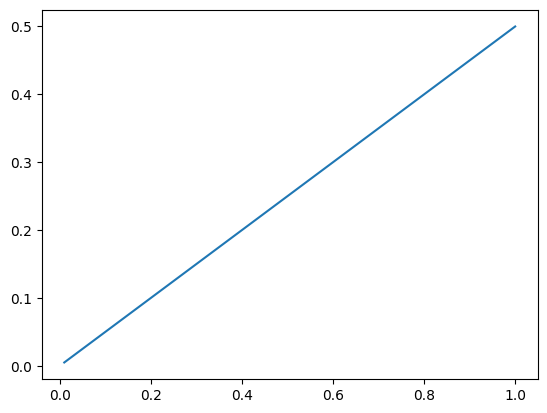

In [ ]:
plt.plot(f, f*0.5)